# EEGNet with LSTM

This notebook provides a modified reimplementation of the previously tested CNN-based EEG classifiers:
   - EEGNet by [Lawhern et al](http://iopscience.iop.org/article/10.1088/177/EEGNet_lstm/1-2552/aace8c/meta).
      - Modifications to make it better suited for short-length windows
      - Memory is added after the "feature extraction" layers, the CNN layers, in the form of a LSTM layer

This notebook works in an offline fashion and uses epochs with a length of 3 seconds.
This epoch starts 1 second before the visual queue was given, includes the 1 second the visual queue was shown and ends 1 second after the visual queue was hidden, totalling 3 seconds.
No baseline correction was performed and the raw EEG data was used.
The effective training and testing are done in a half-second window, starting 0.1 seconds after the start of the visual queue.
A window of 0.5 seconds was chosen as it is a common size for sliding window approaches in online systems.
Some alternatives to this setup were also considered, including one alternative performed for all experiment which uses a long, 1.5 seconds, window.


Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. We will use the utility file `bci-master-thesis/code/utils/CLA_dataset.py` to work with this data. The data was stored as FIF files, which are included in [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

<hr><hr>

## Table of Contents

- Checking requirements
   - Correct Anaconda environment
   - Correct module access
   - Correct file access
   - Checking TensorFlow support
- Same subject, same session: EEGNet bidirectional LSTM
   - Results
   - Longer window experiment (TODO)
- Same subject, same session: EEGNet with bidirectional ConvLSTM2D
   - Results
   - Longer window experiment (TODO)
- Same subject, new session: EEGNet bidirectional LSTM
   - Results
   - Longer window experiment (TODO)
- Same subject, new session: EEGNet with bidirectional ConvLSTM2D
   - Results
   - Longer window experiment (TODO)
- New subject: EEGNet bidirectional LSTM (TODO)
   - Results (TODO)
   - Longer window experiment (TODO)
- New subject: EEGNet with bidirectional ConvLSTM2D (TODO)
   - Results (TODO)
   - Longer window experiment (TODO)

<hr><hr>

## Checking requirements

### Correct Anaconda environment

The `bci-master-thesis` Anaconda environment should be active to ensure proper support. Installation instructions are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

In [1]:
####################################################
# CHECKING FOR RIGHT ANACONDA ENVIRONMENT
####################################################

import os
from platform import python_version
from pathlib import Path
from copy import copy

print(f"Active environment: {os.environ['CONDA_DEFAULT_ENV']}")
print(f"Correct environment: {os.environ['CONDA_DEFAULT_ENV'] == 'bci-master-thesis'}")
print(f"\nPython version: {python_version()}")
print(f"Correct Python version: {python_version() == '3.8.10'}")

Active environment: bci-master-thesis
Correct environment: True

Python version: 3.8.10
Correct Python version: True


<hr>

### Correct module access

The following code block will load in all required modules.

In [2]:
####################################################
# LOADING MODULES
####################################################

# allow reloading of libraries
import importlib

# Load util function file
import sys
sys.path.append('../utils')
import CLA_dataset
import TF_tools
importlib.reload(CLA_dataset)
importlib.reload(TF_tools)

# IO functions
from IPython.utils import io

# Set logging level for MNE before loading MNE
os.environ['MNE_LOGGING_LEVEL'] = 'WARNING'

# Modules tailored for EEG data
import mne; print(f"MNE version (1.0.2 recommended): {mne.__version__}")

# EEGNet model
import EEGNet_with_lstm
from EEGNet_with_lstm import EEGNet_bidirectional_lstm, EEGNet_lstm_1Dconv

# Data manipulation modules
import numpy as np; print(f"Numpy version (1.21.5 recommended): {np.__version__}")
import pandas as pd; print(f"Pandas version (1.4.1 recommended): {pd.__version__}")
import copy

# ML libraries
import sklearn;  print(f"Scikit-learn version (1.0.2 recommended): {sklearn.__version__}")
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import OneHotEncoder

# Deep Learning libraries
import tensorflow as tf;  print(f"TensorFlow version (2.8.0 recommended): {tf.__version__}")

import keras; print(f"Keras version (2.8.0 recommended): {keras.__version__}")
from keras.callbacks import ModelCheckpoint

# Storing files
import pickle;  print(f"Pickle version (4.0 recommended): {pickle.format_version}")

# Plotting
import matplotlib; print(f"Matplotlib version (3.5.1 recommended): {matplotlib.__version__}")
import matplotlib.pyplot as plt

MNE version (1.0.2 recommended): 1.0.2
Numpy version (1.21.5 recommended): 1.21.5
Pandas version (1.4.1 recommended): 1.4.1
Scikit-learn version (1.0.2 recommended): 1.0.2
TensorFlow version (2.8.0 recommended): 2.8.0
Keras version (2.8.0 recommended): 2.8.0
Pickle version (4.0 recommended): 4.0
Matplotlib version (3.5.1 recommended): 3.5.1


<hr>

### Correct file access

As mentioned, this notebook uses a database provided by [Kaya et al](https://doi.org/10.1038/sdata.2018.211). The CLA dataset in particular. Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. The following code block checks if all required files are available.

In [3]:
####################################################
# CHECKING FILE ACCESS
####################################################

# Use util to determine if we have access
print("Full Matlab CLA file access: " + str(CLA_dataset.check_matlab_files_availability()))
print("Full MNE CLA file access: " + str(CLA_dataset.check_mne_files_availability()))

Full Matlab CLA file access: True
Full MNE CLA file access: True


<hr>

### Checking TensorFlow support

If you want to use TensorFlow with GPU acceleration, the below codeblock can help you gather insight.

To launch the tensorboard use the following command in the `paper-notebooks` folder, be sure to have the right environments active:
- Windows: `tensorboard --logdir=./logs/`
- MacOS: `tensorboard --logdir='./logs/'`

In [4]:
TF_tools.check_tf_cpu_gpu_presence()

There are 1 CPUs available under the names:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


There are 1 GPUs available under the names:
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


<hr><hr>

## Same subject, same session: EEGNet bidirectional LSTM 

As discussed in the master's thesis, training and testing a classification system can happen using multiple strategies.
A classifier may be trained on a singular subject, using a singular session and testing on that same session.
This is an over-optimistic testing scenario and has a great risk of overfitting with poor generalisation to new sessions or new subjects but can be an okay baseline test to see if *at least something* can be learned.
Just like we did for the CSP approaches, we do this for the EEGNet model as well.


This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the last recorded session of each of these participants, thus the one where the participant has the most experience
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We split the data in a train/test dataset with 20% test data balanced over all MI classes
   - We use the parameters for EEGNet as found in the experimental notebook `6-DL-based-classification.ipynb`:
      - We input the raw data, which is not baseline corrected, but multiply it by 1000000 to combat the scaling that MNE does per default.
         - This means that we only use the data from the window, so it is easier adoptable to a live setting.
      - We used the modified EEGNet model with memory provided through the `EEGNet_with_lstm.py` util file with the following settings:
         - nb_classes = 3 (int, number of classes to classify)
         - Chans = 21 (number of channels in the EEG dat)
         - Samples = 100 (number of time points in the EEG data - default: 128)
         - dropoutRate = 0.5 (dropout fraction - default: 0.5)
         - kernLength = 50 (length of temporal convolution in first layer. Suggested: half the sampling rate - default: 64)
         - F1 = 8 (number of temporal filters - default: 8)
         - F2 = 16 (number of pointwise filters - default: 16)
         - D = 2 (number of spatial filters to learn within each temporal convolution - default: 2)
         - norm_rate = 0.25 (Normalisation rate - default: 0.25)
         - dropoutType = 'SpatialDropout2D' (Either SpatialDropout2D or Dropout, passed as a string - default: Dropout)
         - LSTM_size = 64
         - lstm_dropout = 0.6
         - lstm_l1 = 0.0005
         - lstm_l2 = 0.0005
      - We trained for 1000 epochs due to the increased training time compared to EEGNet and the fast convergence, knowing it would overfit pretty quickly, saving the best model based on best validation accuracy and validation loss (0.25 validation split - equal size as true test split)
   - We record the validation accuracy and loss over time for monitoring the training and test on the seperate test set

In [5]:
####################################################
# MODEL OVERVIEW
####################################################

EEGNet_bidirectional_lstm(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    F2 = 16, # number of pointwise filters. (default: 16)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.3, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    LSTM_size = 64, # Amount of units in LSTM layer
    ltsm_dropout = 0.6,
    ltsm_l1 = 0.0005,
    ltsm_l2 = 0.0005
).summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 21, 100, 8)        400       
                                                                 
 batch_normalization (BatchN  (None, 21, 100, 8)       32        
 ormalization)                                                   
                                                                 
 depthwise_conv2d (Depthwise  (None, 1, 100, 16)       336       
 Conv2D)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 1, 100, 16)       64        
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 1, 100, 16)        0         
                                                        

In [6]:
####################################################
# TRAINING EEGNET FOR EACH SUBJECT AND SESSION
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

do_experiment = False # Long experiment disabled per default

# Create the TensorFlow Keras model
keras_eegnet_bidirectional_lstm_model = EEGNet_bidirectional_lstm(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    F2 = 16, # number of pointwise filters. (default: 16)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.3, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    LSTM_size = 64, # Amount of units in LSTM layer
    ltsm_dropout = 0.6,
    ltsm_l1 = 0.0005,
    ltsm_l2 = 0.0005
    )

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                print("")
                print("####################################################")
                print(f"# TRAINING FOR SUBJECT {subject_id}")
                print("####################################################")
                print("")
                ###################### PREPARE DATA ######################
                
                with io.capture_output():
                        # Get MNE raw object for latest recording of that subject
                        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_id)
                        
                        # Get epochs for that MNE raw
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Convert the labels to OHE labels as needed for Keras
                labels = labels.reshape(-1, 1)
                ohe = OneHotEncoder()
                labels = ohe.fit_transform(labels).toarray()
                
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Fix scaling sensitivity as MNE stores as data * 10e-6
                mne_epochs_data = mne_epochs_data * 1000000
                
                # Create a test and train split
                X_train, X_test, y_train, y_test = train_test_split(mne_epochs_data,
                                                                    labels,
                                                                    test_size = 0.2,
                                                                    shuffle= True,
                                                                    stratify= labels,                                                    
                                                                    random_state= 1998)
                
                # Store the train and test data so the best model can be retrained later
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/testdata-x.pickle", 'wb') as file:
                        pickle.dump(X_test, file)
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/testdata-y.pickle", 'wb') as file:
                        pickle.dump(y_test, file)
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/traindata-x.pickle", 'wb') as file:
                        pickle.dump(X_train, file)
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/traindata-y.pickle", 'wb') as file:
                        pickle.dump(y_train, file)
                        
                # Store the OHE encoder to enable same conversion later
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/ohe-encoder.pickle", 'wb') as file:
                        pickle.dump(ohe, file)
                        
                print(f"Shape of all data (epochs, channels, samples): {np.shape(mne_epochs_data)}")
                print(f"Shape of train data (epochs, channels, samples): {np.shape(X_train)}")
                print(f"Shape of test data (epochs, channels, samples): {np.shape(X_test)}")
                
                
                ###################### PREPARE MODEL ######################
                
                # Names for model
                best_base_model_filename = f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/trained_model" 
                tensorboard_name = f"paper-notebook7_eegnetlstm_singlesession_subject{subject_id}" # log name for tensorboard
                
                # Create copy of the model that needs training
                trained_model = keras.models.clone_model(keras_eegnet_bidirectional_lstm_model)
                
                # Compile the model so it can be fitted (loss and optimizer from EEGNet paper)
                trained_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
                
                # Train model with GPU
                # NOTE: change GPU to CPU if no GPU present
                with tf.device('/gpu:0'):
                        history = trained_model.fit(
                                x= X_train,
                                y= y_train,
                                batch_size= 128, # Default: 32
                                epochs= 1000, # Default: 500 (EEGNet paper)
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                            TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                            TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_split= 0.25,
                                shuffle= True,
                                sample_weight= None, # Can be interesting due to time series
                                use_multiprocessing=True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del trained_model
                del best_base_model_filename
                del tensorboard_name
                del labels
                del file
                del history
                del X_train
                del X_test
                del ohe
                del y_train
                del y_test
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset
del keras_eegnet_bidirectional_lstm_model

#### Results

EEGNet: 

| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.8333 @ epoch 1262                  | 0.4747 @ epoch 1959              | 0.7656                                           | 0.7708                                            |
| C           | 0.9167 @ epoch 2497                  | 0.3088 @ epoch 1653              | 0.8906                                           | 0.8906                                            |
| E           | 0.9215 @ epoch 1010                  | 0.2724 @ epoch 981               | 0.8586                                           | 0.8691                                            |

EEGNet with biderectional LSTM:

| **Subject** | **EEGNet LSTM: best validation accuracy** | **EEGNet LSTM: best validation loss** | **EEGNet LSTM: test split accuracy (best acc model)** | **EEGNet LSTM: test split accuracy (best loss model)** |
|-------------|-------------------------------------------|---------------------------------------|-------------------------------------------------------|--------------------------------------------------------|
| B           | 0.8021 @ epoch 75                         | 0.5685 @ epoch 170                    | 0.7083                                                | 0.7135                                                 |
| C           | 0.901 @ epoch 301                         | 0.3569 @ epoch 376                    | 0.9062                                                | 0.8958                                                 |
| E           | 0.9058 @ epoch 478                        | 0.3463 @ epoch 400                    | 0.8272                                                | 0.8272                                                 |

With comparable results it is clear that the extension didn't yield improvements nor caused any major issues.
This might suggest that there is just not more information in the data since all results from all these complex models are so comparable for this experiment type.
One noticeable thing is that there is a far greater chance on overfitting, requiring far more extreme dropout.
This is to be expected given the amount of trainable parameters is increased in such an extreme manner.
However, the experiment setup stores both the model with the best validation accuracy and best loss accuracy, so the final obtained models are not really influenced by overfitting behaviour.
The longer windows might aid in reducing this overfitting phenomenon due to the greater amount of data.

The training plots for the validation scores are given below.
B is dark blue, C is light blue and E is light green.


![Accuracy plot](figures/7/EEGNet_lstm/samesubject_samesession/accuracy.png)
![Loss plot](figures/7/EEGNet_lstm/samesubject_samesession/loss.png)


####################################################
# RESULTS FOR SUBJECT B
####################################################

#### results of training ####
Best training accuracy (max) 0.9045 @ epoch 858
Best training loss (min) 0.3362 @ epoch 997

Best validation accuracy (max) 0.8021 @ epoch 75
Best validation loss (min) 0.5685 @ epoch 170

#### results for highest accuracy model ####
Accuracy of: 0.7083


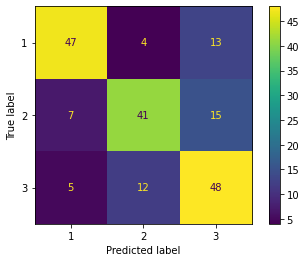


#### results for lowest loss model ####
Accuracy of: 0.7135


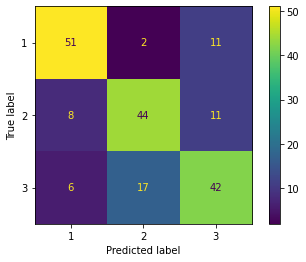


####################################################
# RESULTS FOR SUBJECT C
####################################################

#### results of training ####
Best training accuracy (max) 0.9635 @ epoch 935
Best training loss (min) 0.1744 @ epoch 950

Best validation accuracy (max) 0.901 @ epoch 301
Best validation loss (min) 0.3569 @ epoch 376

#### results for highest accuracy model ####
Accuracy of: 0.9062


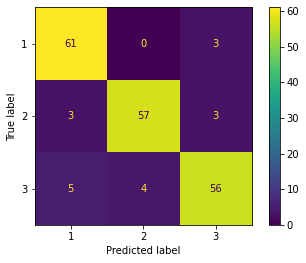


#### results for lowest loss model ####
Accuracy of: 0.8958


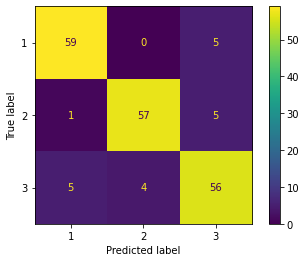


####################################################
# RESULTS FOR SUBJECT E
####################################################

#### results of training ####
Best training accuracy (max) 0.9302 @ epoch 929
Best training loss (min) 0.2418 @ epoch 982

Best validation accuracy (max) 0.9058 @ epoch 478
Best validation loss (min) 0.3463 @ epoch 400

#### results for highest accuracy model ####
Accuracy of: 0.8272


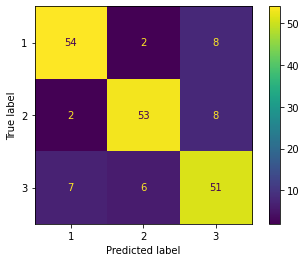


#### results for lowest loss model ####
Accuracy of: 0.8272


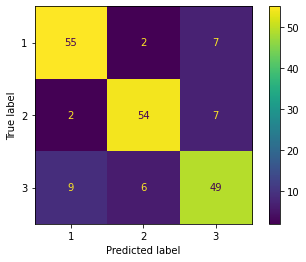

In [7]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get data from files
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/testdata-x.pickle", 'rb') as f:
        X_test = pickle.load(f)
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/testdata-y.pickle", 'rb') as f:
        y_test = pickle.load(f)
        
    # Get OHE from file
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
        
    # Convert OHE labels back to true labels
    y_test = ohe.inverse_transform(y_test)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id

<hr><hr>

## Same subject, same session: EEGNet with bidirectional ConvLSTM2D

As discussed in the master's thesis, training and testing a classification system can happen using multiple strategies.
A classifier may be trained on a singular subject, using a singular session and testing on that same session.
This is an over-optimistic testing scenario and has a great risk of overfitting with poor generalisation to new sessions or new subjects but can be an okay baseline test to see if *at least something* can be learned.
Just like we did for the CSP approaches, we do this for the EEGNet model as well.


This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the last recorded session of each of these participants, thus the one where the participant has the most experience
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We split the data in a train/test dataset with 20% test data balanced over all MI classes
   - We use the parameters for EEGNet as found in the experimental notebook `6-DL-based-classification.ipynb`:
      - We input the raw data, which is not baseline corrected, but multiply it by 1000000 to combat the scaling that MNE does per default.
         - This means that we only use the data from the window, so it is easier adoptable to a live setting.
      - We used the modified EEGNet model with memory provided through the `EEGNet_with_lstm.py` util file with the following settings:
         - nb_classes = 3 (int, number of classes to classify)
         - Chans = 21 (number of channels in the EEG dat)
         - Samples = 100 (number of time points in the EEG data - default: 128)
         - dropoutRate = 0.5 (dropout fraction - default: 0.5)
         - kernLength = 50 (length of temporal convolution in first layer. Suggested: half the sampling rate - default: 64)
         - F1 = 8 (number of temporal filters - default: 8)
         - F2 = 16 (number of pointwise filters - default: 16)
         - D = 2 (number of spatial filters to learn within each temporal convolution - default: 2)
         - norm_rate = 0.25 (Normalisation rate - default: 0.25)
         - dropoutType = 'SpatialDropout2D' (Either SpatialDropout2D or Dropout, passed as a string - default: Dropout)
         - lstm_filters = 40
         - lstm_kernel_size = 9
         - ltsm_dropout = 0.7
         - ltsm_l1 = 0.00005
         - ltsm_l2 = 0.00005
      - We trained for 500 epochs due to the increased training time, saving the best model based on best validation accuracy and validation loss (0.25 validation split - equal size as true test split)
   - We record the validation accuracy and loss over time for monitoring the training and test on the seperate test set

In [8]:
####################################################
# MODEL OVERVIEW
####################################################

EEGNet_lstm_1Dconv(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.25, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    lstm_filters = 40, # Amount of filters for LSTM layer Conv1D. Default: 32
    lstm_kernel_size = 9, # Kernels size for LSTM layer Conv1D.
    ltsm_dropout= 0.7,
    ltsm_l1 = 0.00005, 
    ltsm_l2 = 0.00005
).summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 21, 100, 1)]      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 100, 8)        400       
                                                                 
 batch_normalization_6 (Batc  (None, 21, 100, 8)       32        
 hNormalization)                                                 
                                                                 
 depthwise_conv2d_2 (Depthwi  (None, 1, 100, 16)       336       
 seConv2D)                                                       
                                                                 
 batch_normalization_7 (Batc  (None, 1, 100, 16)       64        
 hNormalization)                                                 
                                                             

In [9]:
####################################################
# TRAINING EEGNET FOR EACH SUBJECT AND SESSION
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

do_experiment = False # Long experiment disabled per default

# Create the TensorFlow Keras model
keras_eegnet_lstm_1Dconv_model = EEGNet_lstm_1Dconv(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.25, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    lstm_filters = 40, # Amount of filters for LSTM layer Conv1D. Default: 32
    lstm_kernel_size = 9, # Kernels size for LSTM layer Conv1D.
    ltsm_dropout= 0.7,
    ltsm_l1 = 0.00005,
    ltsm_l2 = 0.00005
)

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                print("")
                print("####################################################")
                print(f"# TRAINING FOR SUBJECT {subject_id}")
                print("####################################################")
                print("")
                ###################### PREPARE DATA ######################
                
                with io.capture_output():
                        # Get MNE raw object for latest recording of that subject
                        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_id)
                        
                        # Get epochs for that MNE raw
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Convert the labels to OHE labels as needed for Keras
                labels = labels.reshape(-1, 1)
                ohe = OneHotEncoder()
                labels = ohe.fit_transform(labels).toarray()
                
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Fix scaling sensitivity as MNE stores as data * 10e-6
                mne_epochs_data = mne_epochs_data * 1000000
                
                # Create a test and train split
                X_train, X_test, y_train, y_test = train_test_split(mne_epochs_data,
                                                                    labels,
                                                                    test_size = 0.2,
                                                                    shuffle= True,
                                                                    stratify= labels,                                                    
                                                                    random_state= 1998)
                
                
                
                # Store the train and test data so the best model can be retrained later
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/testdata-x.pickle", 'wb') as file:
                        pickle.dump(X_test, file)
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/testdata-y.pickle", 'wb') as file:
                        pickle.dump(y_test, file)
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/traindata-x.pickle", 'wb') as file:
                        pickle.dump(X_train, file)
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/traindata-y.pickle", 'wb') as file:
                        pickle.dump(y_train, file)
                        
                # Store the OHE encoder to enable same conversion later
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/ohe-encoder.pickle", 'wb') as file:
                        pickle.dump(ohe, file)
                        
                print(f"Shape of all data (epochs, channels, samples): {np.shape(mne_epochs_data)}")
                print(f"Shape of train data (epochs, channels, samples): {np.shape(X_train)}")
                print(f"Shape of test data (epochs, channels, samples): {np.shape(X_test)}")
                
                
                ###################### PREPARE MODEL ######################
                
                # Names for model
                best_base_model_filename = f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/trained_model" 
                tensorboard_name = f"paper-notebook7_eegnetlstmconv_singlesession_subject{subject_id}" # log name for tensorboard
                
                # Create copy of the model that needs training
                # Create copy of the model that needs training
                trained_model = keras.models.clone_model(keras_eegnet_lstm_1Dconv_model)
                
                # Compile the model so it can be fitted (loss and optimizer from ShallowConvNet paper)
                trained_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
                
                # Train model with GPU
                # NOTE: change GPU to CPU if no GPU present
                with tf.device('/gpu:0'):
                        history = trained_model.fit(
                                x= X_train,
                                y= y_train,
                                batch_size= 128, # Default: 32
                                epochs= 500, # Default: 500 (EEGNet paper)
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                            TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                            TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_split= 0.25,
                                shuffle= True,
                                sample_weight= None, # Can be interesting due to time series
                                use_multiprocessing=True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del trained_model
                del best_base_model_filename
                del tensorboard_name
                del labels
                del file
                del history
                del X_train
                del X_test
                del ohe
                del y_train
                del y_test
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset
del keras_eegnet_lstm_1Dconv_model

#### Results

EEGNet: 

| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.8333 @ epoch 1262                  | 0.4747 @ epoch 1959              | 0.7656                                           | 0.7708                                            |
| C           | 0.9167 @ epoch 2497                  | 0.3088 @ epoch 1653              | 0.8906                                           | 0.8906                                            |
| E           | 0.9215 @ epoch 1010                  | 0.2724 @ epoch 981               | 0.8586                                           | 0.8691                                            |

EEGNet with 1D conv LSTM:

| **Subject** | **EEGNet LSTM conv: best validation accuracy** | **EEGNet LSTM conv: best validation loss** | **EEGNet LSTM conv: test split accuracy (best acc model)** | **EEGNet LSTM conv: test split accuracy (best loss model)** |
|-------------|------------------------------------------------|--------------------------------------------|------------------------------------------------------------|-------------------------------------------------------------|
| B           | 0.8177 @ epoch 448                             | 0.5194 @ epoch 345                         | 0.7083                                                     | 0.6927                                                      |
| C           | 0.8906 @ epoch 187                             | 0.3887 @ epoch 44                          | 0.8854                                                     | 0.8854                                                      |
| E           | 0.9215 @ epoch 339                             | 0.2673 @ epoch 443                         | 0.8429                                                     | 0.8639                                                      |


Again, for the most part results seems comparable although the result for subject B is considerably lower then EEGNet.
The training plots for the validation scores are given below.
B is dark blue, C is light blue and E is light green.

![Accuracy plot](figures/7/EEGNet_convlstm/samesubject_samesession/accuracy.png)
![Loss plot](figures/7/EEGNet_convlstm/samesubject_samesession/loss.png)


####################################################
# RESULTS FOR SUBJECT B
####################################################

#### results of training ####
Best training accuracy (max) 0.8299 @ epoch 350
Best training loss (min) 0.4749 @ epoch 464

Best validation accuracy (max) 0.8177 @ epoch 448
Best validation loss (min) 0.5194 @ epoch 345

#### results for highest accuracy model ####
Accuracy of: 0.7083


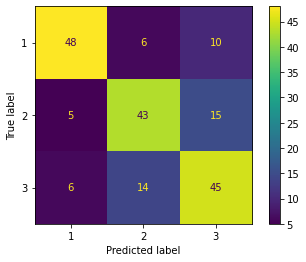


#### results for lowest loss model ####
Accuracy of: 0.6927


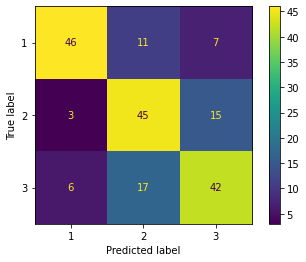


####################################################
# RESULTS FOR SUBJECT C
####################################################

#### results of training ####
Best training accuracy (max) 0.9443 @ epoch 390
Best training loss (min) 0.2089 @ epoch 485

Best validation accuracy (max) 0.8906 @ epoch 187
Best validation loss (min) 0.3887 @ epoch 442

#### results for highest accuracy model ####
Accuracy of: 0.8854


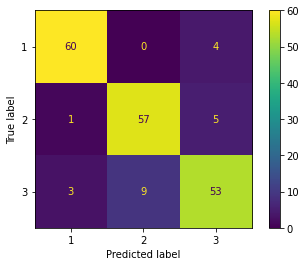


#### results for lowest loss model ####
Accuracy of: 0.8854


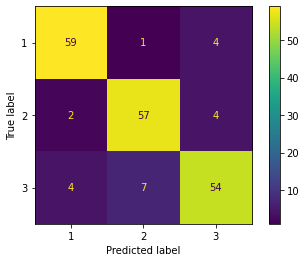


####################################################
# RESULTS FOR SUBJECT E
####################################################

#### results of training ####
Best training accuracy (max) 0.911 @ epoch 473
Best training loss (min) 0.275 @ epoch 473

Best validation accuracy (max) 0.9215 @ epoch 339
Best validation loss (min) 0.2673 @ epoch 443

#### results for highest accuracy model ####
Accuracy of: 0.8429


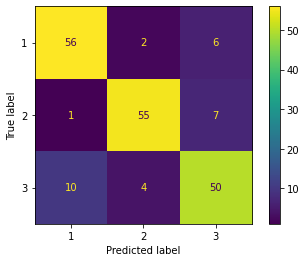


#### results for lowest loss model ####
Accuracy of: 0.8639


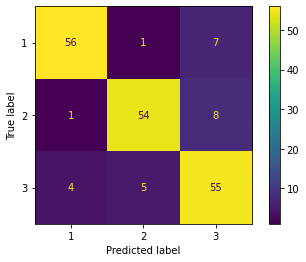

In [10]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get data from files
    with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/testdata-x.pickle", 'rb') as f:
        X_test = pickle.load(f)
    with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/testdata-y.pickle", 'rb') as f:
        y_test = pickle.load(f)
        
    # Get OHE from file
    with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
        
    # Convert OHE labels back to true labels
    y_test = ohe.inverse_transform(y_test)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id

<hr><hr>

## Same subject, new session: EEGNet bidirectional LSTM

As discussed in the master's thesis, training and testing a classification system can happen using multiple strategies.
A classifier may be trained on a singular subject, but by using one or more sessions for training and testing on a new, unseen session.
This is a harder task than the previous one, where training and testing were done for the same session.
This section will train the same classifiers for the same participants as before but by using the first two datasets as training data and the third and final session of each participant as a standalone test set which is not used in training.


This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the first two recorded session of each of these participants for training and the last for testing.
      - Thus, the CV scores are on the test split for the training data whilst the independent test set is from the unseen session not used during training. This avoids data leakage.
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We use the parameters for EEGNet as found in the experimental notebook `6-DL-based-classification.ipynb`:
      - We input the raw data, which is not baseline corrected, but multiply it by 1000000 to combat the scaling that MNE does per default.
         - This means that we only use the data from the window, so it is easier adoptable to a live setting.
      - We used the modified EEGNet model with memory provided through the `EEGNet_with_lstm.py` util file with the following settings:
         - nb_classes = 3 (int, number of classes to classify)
         - Chans = 21 (number of channels in the EEG dat)
         - Samples = 100 (number of time points in the EEG data - default: 128)
         - dropoutRate = 0.5 (dropout fraction - default: 0.5)
         - kernLength = 50 (length of temporal convolution in first layer. Suggested: half the sampling rate - default: 64)
         - F1 = 8 (number of temporal filters - default: 8)
         - F2 = 16 (number of pointwise filters - default: 16)
         - D = 2 (number of spatial filters to learn within each temporal convolution - default: 2)
         - norm_rate = 0.25 (Normalisation rate - default: 0.25)
         - dropoutType = 'SpatialDropout2D' (Either SpatialDropout2D or Dropout, passed as a string - default: Dropout)
         - LSTM_size = 64
         - lstm_dropout = 0.6
         - lstm_l1 = 0.0005
         - lstm_l2 = 0.0005
      - We trained for 2500 epochs due to the increased amount of data, saving the best model based on best validation accuracy and validation loss (0.3 validation split)
   - We record the validation accuracy and loss over time for monitoring the training and test on the seperate test set

In [11]:
####################################################
# MODEL OVERVIEW
####################################################

EEGNet_bidirectional_lstm(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    F2 = 16, # number of pointwise filters. (default: 16)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.3, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    LSTM_size = 64, # Amount of units in LSTM layer
    ltsm_dropout = 0.6,
    ltsm_l1 = 0.0005,
    ltsm_l2 = 0.0005
).summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 21, 100, 8)        400       
                                                                 
 batch_normalization_10 (Bat  (None, 21, 100, 8)       32        
 chNormalization)                                                
                                                                 
 depthwise_conv2d_4 (Depthwi  (None, 1, 100, 16)       336       
 seConv2D)                                                       
                                                                 
 batch_normalization_11 (Bat  (None, 1, 100, 16)       64        
 chNormalization)                                                
                                                                 
 activation_6 (Activation)   (None, 1, 100, 16)        0         
                                                      

In [12]:
####################################################
# TRAINING EEGNET ON EACH SUBJECT AND TWO SESSIONS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

do_experiment = False # Long experiment disabled per default

# Create the TensorFlow Keras model
keras_eegnet_bidirectional_lstm_model = EEGNet_bidirectional_lstm(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    F2 = 16, # number of pointwise filters. (default: 16)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.3, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    LSTM_size = 64, # Amount of units in LSTM layer
    ltsm_dropout = 0.6,
    ltsm_l1 = 0.0005,
    ltsm_l2 = 0.0005
    )

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                print("")
                print("####################################################")
                print(f"# TRAINING FOR SUBJECT {subject_id}")
                print("####################################################")
                print("")
                ###################### PREPARE DATA ######################
                
                with io.capture_output():
                        # Get all training data (all but last session of participant)
                        mne_raws= CLA_dataset.get_all_but_last_raw_mne_data_for_subject(subject_id= subject_id)
                        
                        # Combine training data into singular mne raw
                        mne_raw = mne.concatenate_raws(mne_raws)
                        
                        # Delete all raws since concat changes them
                        del mne_raws
                        
                        # Get epochs for that MNE raw
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Convert the labels to OHE labels as needed for Keras
                labels = labels.reshape(-1, 1)
                ohe = OneHotEncoder()
                labels = ohe.fit_transform(labels).toarray()
                
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Fix scaling sensitivity as MNE stores as data * 10e-6
                mne_epochs_data = mne_epochs_data * 1000000
                        
                # Store the OHE encoder to enable same conversion later
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_differentsession/subject{subject_id}/ohe-encoder.pickle", 'wb') as file:
                        pickle.dump(ohe, file)
                        
                print(f"Shape of all data (epochs, channels, samples): {np.shape(mne_epochs_data)}")
                
                
                ###################### PREPARE MODEL ######################
                
                # Names for model
                best_base_model_filename = f"saved_variables/7/EEGNet_lstm/samesubject_differentsession/subject{subject_id}/trained_model" 
                tensorboard_name = f"paper-notebook7_eegnetlstm_newsession_subject{subject_id}" # log name for tensorboard
                
                # Create copy of the model that needs training
                trained_model = keras.models.clone_model(keras_eegnet_bidirectional_lstm_model)
                
                # Compile the model so it can be fitted (loss and optimizer from EEGNet paper)
                trained_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
                
                # Train model with GPU
                # NOTE: change GPU to CPU if nog GPU present
                with tf.device('/gpu:0'):
                        history = trained_model.fit(
                                x= mne_epochs_data,
                                y= labels,
                                batch_size= 128, # Default: 32
                                epochs= 1000, # Default: 500 (EEGNet paper)
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                            TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                            TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_split= 0.3,
                                shuffle= True,
                                sample_weight= None, # Can be interesting due to time series
                                use_multiprocessing=True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_differentsession/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del trained_model
                del best_base_model_filename
                del tensorboard_name
                del labels
                del file
                del history
                del ohe
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset
del keras_eegnet_bidirectional_lstm_model

#### Results

EEGNet

| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.6927 @ epoch 1473                  | 0.761 @ epoch 1472               | 0.65                                             | 0.6573                                            |
| C           | 0.8837 @ epoch 1159                  | 0.3827 @ epoch 584               | 0.7132                                           | 0.6986                                            |
| E           | 0.7674 @ epoch 782                   | 0.5884 @ epoch 1028              | 0.7068                                           | 0.7246                                            |

EEGNet with biderectional LSTM:

| **Subject** | **EEGNet LSTM: best validation accuracy** | **EEGNet LSTM: best validation loss** | **EEGNet LSTM: test split accuracy (best acc model)** | **EEGNet LSTM: test split accuracy (best loss model)** |
|-------------|------------------------------------------------|--------------------------------------------|------------------------------------------------------------|-------------------------------------------------------------|
| B           | 0.6458 @ epoch 177                             | 0.8297 @ epoch 147                         | 0.6302                                                     | 0.6188                                                      |
| C           | 0.8681 @ epoch 947                             | 0.4117 @ epoch 782                         | 0.6726                                                     | 0.6851                                                      |
| E           | 0.7361 @ epoch 166                             | 0.6617 @ epoch 75                          | 0.6513                                                     | 0.6702                                                      |

Again, no real increase nor decrease in performance is made with the LSTM extension

The training plots are given below.
B is dark blue, C is light blue and E is light green.

![Accuracy plot](figures/7/EEGNet_lstm/samesubject_newsession/Accuracy.png)
![Loss plot](figures/7/EEGNet_lstm/samesubject_newsession/Loss.png)


####################################################
# RESULTS FOR SUBJECT B
####################################################

#### results of training ####
Best training accuracy (max) 0.8256 @ epoch 998
Best training loss (min) 0.5287 @ epoch 1000

Best validation accuracy (max) 0.6458 @ epoch 177
Best validation loss (min) 0.8297 @ epoch 147

#### results for highest accuracy model ####
Accuracy of: 0.6302


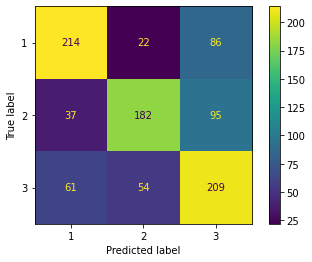


#### results for lowest loss model ####
Accuracy of: 0.6188


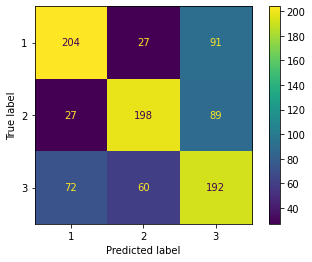


####################################################
# RESULTS FOR SUBJECT C
####################################################

#### results of training ####
Best training accuracy (max) 0.9554 @ epoch 698
Best training loss (min) 0.1778 @ epoch 943

Best validation accuracy (max) 0.8681 @ epoch 947
Best validation loss (min) 0.4117 @ epoch 782

#### results for highest accuracy model ####
Accuracy of: 0.6726


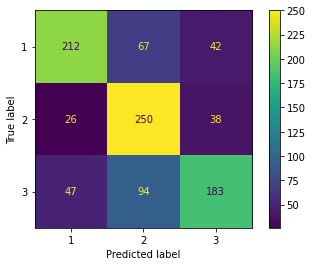


#### results for lowest loss model ####
Accuracy of: 0.6851


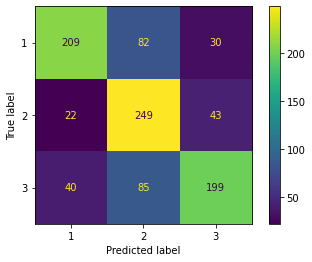


####################################################
# RESULTS FOR SUBJECT E
####################################################

#### results of training ####
Best training accuracy (max) 0.8553 @ epoch 948
Best training loss (min) 0.413 @ epoch 948

Best validation accuracy (max) 0.7361 @ epoch 166
Best validation loss (min) 0.6617 @ epoch 75

#### results for highest accuracy model ####
Accuracy of: 0.6513


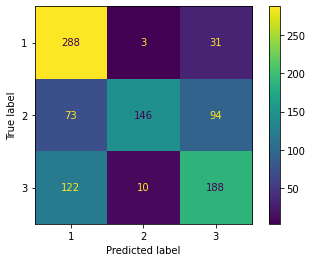


#### results for lowest loss model ####
Accuracy of: 0.6702


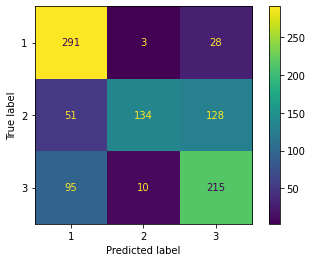

In [13]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/7/EEGNet_lstm/samesubject_differentsession/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get test data session
    with io.capture_output():
        # Get test data
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_test = mne_epochs.events[:, -1]
        
        # Get a half second window
        X_test = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
        
        # Fix scaling sensitivity as MNE stores as data * 10e-6
        X_test = X_test * 1000000
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
        
    # Get OHE from file
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_differentsession/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_differentsession/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id
del baseline
del end_offset
del start_offset

<hr><hr>

## Same subject, new session: EEGNet with bidirectional ConvLSTM2D

As discussed in the master's thesis, training and testing a classification system can happen using multiple strategies.
A classifier may be trained on a singular subject, but by using one or more sessions for training and testing on a new, unseen session.
This is a harder task than the previous one, where training and testing were done for the same session.
This section will train the same classifiers for the same participants as before but by using the first two datasets as training data and the third and final session of each participant as a standalone test set which is not used in training.


This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the last recorded session of each of these participants, thus the one where the participant has the most experience
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We split the data in a train/test dataset with 20% test data balanced over all MI classes
   - We use the parameters for EEGNet as found in the experimental notebook `6-DL-based-classification.ipynb`:
      - We input the raw data, which is not baseline corrected, but multiply it by 1000000 to combat the scaling that MNE does per default.
         - This means that we only use the data from the window, so it is easier adoptable to a live setting.
      - We used the modified EEGNet model with memory provided through the `EEGNet_with_lstm.py` util file with the following settings:
         - nb_classes = 3 (int, number of classes to classify)
         - Chans = 21 (number of channels in the EEG dat)
         - Samples = 100 (number of time points in the EEG data - default: 128)
         - dropoutRate = 0.5 (dropout fraction - default: 0.5)
         - kernLength = 50 (length of temporal convolution in first layer. Suggested: half the sampling rate - default: 64)
         - F1 = 8 (number of temporal filters - default: 8)
         - F2 = 16 (number of pointwise filters - default: 16)
         - D = 2 (number of spatial filters to learn within each temporal convolution - default: 2)
         - norm_rate = 0.25 (Normalisation rate - default: 0.25)
         - dropoutType = 'SpatialDropout2D' (Either SpatialDropout2D or Dropout, passed as a string - default: Dropout)
         - lstm_filters = 40
         - lstm_kernel_size = 9
         - ltsm_dropout = 0.7
         - ltsm_l1 = 0.00005
         - ltsm_l2 = 0.00005
      - We trained for 500 epochs due to the increased training time, saving the best model based on best validation accuracy and validation loss (0.25 validation split - equal size as true test split)
   - We record the validation accuracy and loss over time for monitoring the training and test on the seperate test set

In [14]:
####################################################
# MODEL OVERVIEW
####################################################

EEGNet_lstm_1Dconv(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.25, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    lstm_filters = 40, # Amount of filters for LSTM layer Conv1D. Default: 32
    lstm_kernel_size = 9, # Kernels size for LSTM layer Conv1D.
    ltsm_dropout= 0.7,
    ltsm_l1 = 0.00005, 
    ltsm_l2 = 0.00005
).summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 21, 100, 1)]      0         
                                                                 
 conv2d_6 (Conv2D)           (None, 21, 100, 8)        400       
                                                                 
 batch_normalization_16 (Bat  (None, 21, 100, 8)       32        
 chNormalization)                                                
                                                                 
 depthwise_conv2d_6 (Depthwi  (None, 1, 100, 16)       336       
 seConv2D)                                                       
                                                                 
 batch_normalization_17 (Bat  (None, 1, 100, 16)       64        
 chNormalization)                                                
                                                           

In [15]:
####################################################
# TRAINING EEGNET ON EACH SUBJECT AND TWO SESSIONS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

do_experiment = True # Long experiment disabled per default

# Create the TensorFlow Keras model
keras_eegnet_lstm_1Dconv_model = EEGNet_lstm_1Dconv(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.25, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    lstm_filters = 40, # Amount of filters for LSTM layer Conv1D. Default: 32
    lstm_kernel_size = 9, # Kernels size for LSTM layer Conv1D.
    ltsm_dropout= 0.7,
    ltsm_l1 = 0.00005,
    ltsm_l2 = 0.00005
)

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                print("")
                print("####################################################")
                print(f"# TRAINING FOR SUBJECT {subject_id}")
                print("####################################################")
                print("")
                ###################### PREPARE DATA ######################
                
                with io.capture_output():
                        # Get all training data (all but last session of participant)
                        mne_raws= CLA_dataset.get_all_but_last_raw_mne_data_for_subject(subject_id= subject_id)
                        
                        # Combine training data into singular mne raw
                        mne_raw = mne.concatenate_raws(mne_raws)
                        
                        # Delete all raws since concat changes them
                        del mne_raws
                        
                        # Get epochs for that MNE raw
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Convert the labels to OHE labels as needed for Keras
                labels = labels.reshape(-1, 1)
                ohe = OneHotEncoder()
                labels = ohe.fit_transform(labels).toarray()
                
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Fix scaling sensitivity as MNE stores as data * 10e-6
                mne_epochs_data = mne_epochs_data * 1000000
                        
                # Store the OHE encoder to enable same conversion later
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/ohe-encoder.pickle", 'wb') as file:
                        pickle.dump(ohe, file)
                        
                print(f"Shape of all data (epochs, channels, samples): {np.shape(mne_epochs_data)}")
                
                
                ###################### PREPARE MODEL ######################
                
                # Names for model
                best_base_model_filename = f"saved_variables/7/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/trained_model" 
                tensorboard_name = f"paper-notebook7_eegnetlstmconv_newsession_subject{subject_id}" # log name for tensorboard
                
                # Create copy of the model that needs training
                trained_model = keras.models.clone_model(keras_eegnet_lstm_1Dconv_model)
                
                # Compile the model so it can be fitted (loss and optimizer from EEGNet paper)
                trained_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
                
                # Train model with GPU
                # NOTE: change GPU to CPU if nog GPU present
                with tf.device('/gpu:0'):
                        history = trained_model.fit(
                                x= mne_epochs_data,
                                y= labels,
                                batch_size= 128, # Default: 32
                                epochs= 500, # Default: 500 (EEGNet paper)
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                            TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                            TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_split= 0.3,
                                shuffle= True,
                                sample_weight= None, # Can be interesting due to time series
                                use_multiprocessing=True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del trained_model
                del best_base_model_filename
                del tensorboard_name
                del labels
                del file
                del history
                del ohe
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset
del keras_eegnet_lstm_1Dconv_model


####################################################
# TRAINING FOR SUBJECT B
####################################################

Shape of all data (epochs, channels, samples): (1918, 21, 100)
Epoch 1/500
11/11 [==============================] - ETA: 0s - loss: 1.1075 - accuracy: 0.3145
Epoch 1: val_loss improved from inf to 1.09878, saving model to saved_variables/7/EEGNet_lstmconv1D/samesubject_differentsession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 1: val_accuracy improved from -inf to 0.42014, saving model to saved_variables/7/EEGNet_lstmconv1D/samesubject_differentsession/subjectB\trained_model_highest_acc_model.hdf5
11/11 [==============================] - 54s 4s/step - loss: 1.1075 - accuracy: 0.3145 - val_loss: 1.0988 - val_accuracy: 0.4201
Epoch 2/500
11/11 [==============================] - ETA: 0s - loss: 1.0986 - accuracy: 0.3644
Epoch 2: val_loss improved from 1.09878 to 1.09742, saving model to saved_variables/7/EEGNet_lstmconv1D/samesubject_differentsess


Epoch 19: val_accuracy did not improve from 0.59549
11/11 [==============================] - 45s 4s/step - loss: 0.9868 - accuracy: 0.5007 - val_loss: 0.9435 - val_accuracy: 0.5538
Epoch 20/500
11/11 [==============================] - ETA: 0s - loss: 0.9766 - accuracy: 0.5231
Epoch 20: val_loss did not improve from 0.94353

Epoch 20: val_accuracy did not improve from 0.59549
11/11 [==============================] - 45s 4s/step - loss: 0.9766 - accuracy: 0.5231 - val_loss: 0.9485 - val_accuracy: 0.5608
Epoch 21/500
11/11 [==============================] - ETA: 0s - loss: 0.9712 - accuracy: 0.5201
Epoch 21: val_loss did not improve from 0.94353

Epoch 21: val_accuracy did not improve from 0.59549
11/11 [==============================] - 45s 4s/step - loss: 0.9712 - accuracy: 0.5201 - val_loss: 0.9622 - val_accuracy: 0.5399
Epoch 22/500
11/11 [==============================] - ETA: 0s - loss: 0.9622 - accuracy: 0.5313
Epoch 22: val_loss did not improve from 0.94353

Epoch 22: val_accurac

11/11 [==============================] - 45s 4s/step - loss: 0.9092 - accuracy: 0.5693 - val_loss: 0.8688 - val_accuracy: 0.6076
Epoch 41/500
11/11 [==============================] - ETA: 0s - loss: 0.8920 - accuracy: 0.5790
Epoch 41: val_loss did not improve from 0.86332

Epoch 41: val_accuracy did not improve from 0.61979
11/11 [==============================] - 47s 4s/step - loss: 0.8920 - accuracy: 0.5790 - val_loss: 0.8721 - val_accuracy: 0.6111
Epoch 42/500
11/11 [==============================] - ETA: 0s - loss: 0.9086 - accuracy: 0.5805
Epoch 42: val_loss did not improve from 0.86332

Epoch 42: val_accuracy did not improve from 0.61979
11/11 [==============================] - 45s 4s/step - loss: 0.9086 - accuracy: 0.5805 - val_loss: 0.8710 - val_accuracy: 0.6007
Epoch 43/500
11/11 [==============================] - ETA: 0s - loss: 0.8862 - accuracy: 0.5857
Epoch 43: val_loss did not improve from 0.86332

Epoch 43: val_accuracy did not improve from 0.61979
11/11 [===============

Epoch 64/500
11/11 [==============================] - ETA: 0s - loss: 0.8739 - accuracy: 0.5999
Epoch 64: val_loss did not improve from 0.83614

Epoch 64: val_accuracy did not improve from 0.64583
11/11 [==============================] - 46s 4s/step - loss: 0.8739 - accuracy: 0.5999 - val_loss: 0.8668 - val_accuracy: 0.5868
Epoch 65/500
11/11 [==============================] - ETA: 0s - loss: 0.8718 - accuracy: 0.5976
Epoch 65: val_loss did not improve from 0.83614

Epoch 65: val_accuracy did not improve from 0.64583
11/11 [==============================] - 44s 4s/step - loss: 0.8718 - accuracy: 0.5976 - val_loss: 0.8465 - val_accuracy: 0.6163
Epoch 66/500
11/11 [==============================] - ETA: 0s - loss: 0.8673 - accuracy: 0.6103
Epoch 66: val_loss did not improve from 0.83614

Epoch 66: val_accuracy did not improve from 0.64583
11/11 [==============================] - 46s 4s/step - loss: 0.8673 - accuracy: 0.6103 - val_loss: 0.8582 - val_accuracy: 0.6163
Epoch 67/500
11/11 [==


Epoch 88: val_accuracy did not improve from 0.64583
11/11 [==============================] - 45s 4s/step - loss: 0.8533 - accuracy: 0.6043 - val_loss: 0.8579 - val_accuracy: 0.6146
Epoch 89/500
11/11 [==============================] - ETA: 0s - loss: 0.8513 - accuracy: 0.6058
Epoch 89: val_loss did not improve from 0.83246

Epoch 89: val_accuracy did not improve from 0.64583
11/11 [==============================] - 45s 4s/step - loss: 0.8513 - accuracy: 0.6058 - val_loss: 0.8522 - val_accuracy: 0.6163
Epoch 90/500
11/11 [==============================] - ETA: 0s - loss: 0.8342 - accuracy: 0.6148
Epoch 90: val_loss did not improve from 0.83246

Epoch 90: val_accuracy did not improve from 0.64583
11/11 [==============================] - 47s 4s/step - loss: 0.8342 - accuracy: 0.6148 - val_loss: 0.8356 - val_accuracy: 0.6337
Epoch 91/500
11/11 [==============================] - ETA: 0s - loss: 0.8508 - accuracy: 0.6133
Epoch 91: val_loss did not improve from 0.83246

Epoch 91: val_accurac

11/11 [==============================] - ETA: 0s - loss: 0.8616 - accuracy: 0.6073
Epoch 112: val_loss did not improve from 0.82562

Epoch 112: val_accuracy did not improve from 0.64931
11/11 [==============================] - 45s 4s/step - loss: 0.8616 - accuracy: 0.6073 - val_loss: 0.8489 - val_accuracy: 0.6337
Epoch 113/500
11/11 [==============================] - ETA: 0s - loss: 0.8389 - accuracy: 0.6185
Epoch 113: val_loss did not improve from 0.82562

Epoch 113: val_accuracy did not improve from 0.64931
11/11 [==============================] - 45s 4s/step - loss: 0.8389 - accuracy: 0.6185 - val_loss: 0.8543 - val_accuracy: 0.6302
Epoch 114/500
11/11 [==============================] - ETA: 0s - loss: 0.8414 - accuracy: 0.6125
Epoch 114: val_loss did not improve from 0.82562

Epoch 114: val_accuracy did not improve from 0.64931
11/11 [==============================] - 45s 4s/step - loss: 0.8414 - accuracy: 0.6125 - val_loss: 0.8452 - val_accuracy: 0.6406
Epoch 115/500
11/11 [======

Epoch 137/500
11/11 [==============================] - ETA: 0s - loss: 0.8284 - accuracy: 0.6311
Epoch 137: val_loss did not improve from 0.82562

Epoch 137: val_accuracy did not improve from 0.64931
11/11 [==============================] - 45s 4s/step - loss: 0.8284 - accuracy: 0.6311 - val_loss: 0.8326 - val_accuracy: 0.6389
Epoch 138/500
11/11 [==============================] - ETA: 0s - loss: 0.8050 - accuracy: 0.6393
Epoch 138: val_loss did not improve from 0.82562

Epoch 138: val_accuracy did not improve from 0.64931
11/11 [==============================] - 45s 4s/step - loss: 0.8050 - accuracy: 0.6393 - val_loss: 0.8572 - val_accuracy: 0.6337
Epoch 139/500
11/11 [==============================] - ETA: 0s - loss: 0.8118 - accuracy: 0.6334
Epoch 139: val_loss did not improve from 0.82562

Epoch 139: val_accuracy did not improve from 0.64931
11/11 [==============================] - 44s 4s/step - loss: 0.8118 - accuracy: 0.6334 - val_loss: 0.8695 - val_accuracy: 0.6146
Epoch 140/500

11/11 [==============================] - 45s 4s/step - loss: 0.8276 - accuracy: 0.6341 - val_loss: 0.8278 - val_accuracy: 0.6337
Epoch 162/500
11/11 [==============================] - ETA: 0s - loss: 0.8126 - accuracy: 0.6066
Epoch 162: val_loss did not improve from 0.82562

Epoch 162: val_accuracy did not improve from 0.65104
11/11 [==============================] - 46s 4s/step - loss: 0.8126 - accuracy: 0.6066 - val_loss: 0.8462 - val_accuracy: 0.6250
Epoch 163/500
11/11 [==============================] - ETA: 0s - loss: 0.8290 - accuracy: 0.6237
Epoch 163: val_loss did not improve from 0.82562

Epoch 163: val_accuracy did not improve from 0.65104
11/11 [==============================] - 45s 4s/step - loss: 0.8290 - accuracy: 0.6237 - val_loss: 0.8372 - val_accuracy: 0.6372
Epoch 164/500
11/11 [==============================] - ETA: 0s - loss: 0.8079 - accuracy: 0.6423
Epoch 164: val_loss did not improve from 0.82562

Epoch 164: val_accuracy did not improve from 0.65104
11/11 [======

11/11 [==============================] - ETA: 0s - loss: 0.7747 - accuracy: 0.6632
Epoch 186: val_loss did not improve from 0.82550

Epoch 186: val_accuracy did not improve from 0.65104
11/11 [==============================] - 46s 4s/step - loss: 0.7747 - accuracy: 0.6632 - val_loss: 0.8811 - val_accuracy: 0.6181
Epoch 187/500
11/11 [==============================] - ETA: 0s - loss: 0.7954 - accuracy: 0.6289
Epoch 187: val_loss did not improve from 0.82550

Epoch 187: val_accuracy did not improve from 0.65104
11/11 [==============================] - 45s 4s/step - loss: 0.7954 - accuracy: 0.6289 - val_loss: 0.8626 - val_accuracy: 0.6215
Epoch 188/500
11/11 [==============================] - ETA: 0s - loss: 0.7982 - accuracy: 0.6513
Epoch 188: val_loss did not improve from 0.82550

Epoch 188: val_accuracy did not improve from 0.65104
11/11 [==============================] - 45s 4s/step - loss: 0.7982 - accuracy: 0.6513 - val_loss: 0.8447 - val_accuracy: 0.6233
Epoch 189/500
11/11 [======

Epoch 211/500
11/11 [==============================] - ETA: 0s - loss: 0.7794 - accuracy: 0.6624
Epoch 211: val_loss did not improve from 0.82550

Epoch 211: val_accuracy did not improve from 0.65104
11/11 [==============================] - 46s 4s/step - loss: 0.7794 - accuracy: 0.6624 - val_loss: 0.8681 - val_accuracy: 0.5972
Epoch 212/500
11/11 [==============================] - ETA: 0s - loss: 0.7875 - accuracy: 0.6505
Epoch 212: val_loss did not improve from 0.82550

Epoch 212: val_accuracy did not improve from 0.65104
11/11 [==============================] - 46s 4s/step - loss: 0.7875 - accuracy: 0.6505 - val_loss: 0.8514 - val_accuracy: 0.6354
Epoch 213/500
11/11 [==============================] - ETA: 0s - loss: 0.8024 - accuracy: 0.6349
Epoch 213: val_loss did not improve from 0.82550

Epoch 213: val_accuracy did not improve from 0.65104
11/11 [==============================] - 44s 4s/step - loss: 0.8024 - accuracy: 0.6349 - val_loss: 0.8474 - val_accuracy: 0.6424
Epoch 214/500

Epoch 236/500
11/11 [==============================] - ETA: 0s - loss: 0.7721 - accuracy: 0.6692
Epoch 236: val_loss did not improve from 0.82550

Epoch 236: val_accuracy did not improve from 0.65104
11/11 [==============================] - 45s 4s/step - loss: 0.7721 - accuracy: 0.6692 - val_loss: 0.8489 - val_accuracy: 0.6233
Epoch 237/500
11/11 [==============================] - ETA: 0s - loss: 0.7788 - accuracy: 0.6669
Epoch 237: val_loss did not improve from 0.82550

Epoch 237: val_accuracy did not improve from 0.65104
11/11 [==============================] - 45s 4s/step - loss: 0.7788 - accuracy: 0.6669 - val_loss: 0.8391 - val_accuracy: 0.6354
Epoch 238/500
11/11 [==============================] - ETA: 0s - loss: 0.7712 - accuracy: 0.6706
Epoch 238: val_loss did not improve from 0.82550

Epoch 238: val_accuracy did not improve from 0.65104
11/11 [==============================] - 45s 4s/step - loss: 0.7712 - accuracy: 0.6706 - val_loss: 0.8460 - val_accuracy: 0.6163
Epoch 239/500

Epoch 261/500
11/11 [==============================] - ETA: 0s - loss: 0.7490 - accuracy: 0.6773
Epoch 261: val_loss did not improve from 0.82550

Epoch 261: val_accuracy did not improve from 0.65104
11/11 [==============================] - 46s 4s/step - loss: 0.7490 - accuracy: 0.6773 - val_loss: 0.8489 - val_accuracy: 0.6267
Epoch 262/500
11/11 [==============================] - ETA: 0s - loss: 0.7669 - accuracy: 0.6759
Epoch 262: val_loss did not improve from 0.82550

Epoch 262: val_accuracy did not improve from 0.65104
11/11 [==============================] - 46s 4s/step - loss: 0.7669 - accuracy: 0.6759 - val_loss: 0.8826 - val_accuracy: 0.6146
Epoch 263/500
11/11 [==============================] - ETA: 0s - loss: 0.7766 - accuracy: 0.6505
Epoch 263: val_loss did not improve from 0.82550

Epoch 263: val_accuracy did not improve from 0.65104
11/11 [==============================] - 45s 4s/step - loss: 0.7766 - accuracy: 0.6505 - val_loss: 0.8492 - val_accuracy: 0.6007
Epoch 264/500

Epoch 286/500
11/11 [==============================] - ETA: 0s - loss: 0.7769 - accuracy: 0.6617
Epoch 286: val_loss did not improve from 0.82550

Epoch 286: val_accuracy did not improve from 0.65104
11/11 [==============================] - 46s 4s/step - loss: 0.7769 - accuracy: 0.6617 - val_loss: 0.8487 - val_accuracy: 0.6319
Epoch 287/500
11/11 [==============================] - ETA: 0s - loss: 0.7783 - accuracy: 0.6721
Epoch 287: val_loss did not improve from 0.82550

Epoch 287: val_accuracy did not improve from 0.65104
11/11 [==============================] - 46s 4s/step - loss: 0.7783 - accuracy: 0.6721 - val_loss: 0.8430 - val_accuracy: 0.6215
Epoch 288/500
11/11 [==============================] - ETA: 0s - loss: 0.7617 - accuracy: 0.6669
Epoch 288: val_loss did not improve from 0.82550

Epoch 288: val_accuracy did not improve from 0.65104
11/11 [==============================] - 45s 4s/step - loss: 0.7617 - accuracy: 0.6669 - val_loss: 0.8272 - val_accuracy: 0.6458
Epoch 289/500

11/11 [==============================] - 45s 4s/step - loss: 0.7476 - accuracy: 0.6773 - val_loss: 0.8715 - val_accuracy: 0.6146
Epoch 311/500
11/11 [==============================] - ETA: 0s - loss: 0.7716 - accuracy: 0.6602
Epoch 311: val_loss did not improve from 0.82550

Epoch 311: val_accuracy did not improve from 0.65451
11/11 [==============================] - 45s 4s/step - loss: 0.7716 - accuracy: 0.6602 - val_loss: 0.8740 - val_accuracy: 0.6076
Epoch 312/500
11/11 [==============================] - ETA: 0s - loss: 0.7931 - accuracy: 0.6535
Epoch 312: val_loss did not improve from 0.82550

Epoch 312: val_accuracy did not improve from 0.65451
11/11 [==============================] - 45s 4s/step - loss: 0.7931 - accuracy: 0.6535 - val_loss: 0.8632 - val_accuracy: 0.6094
Epoch 313/500
11/11 [==============================] - ETA: 0s - loss: 0.7515 - accuracy: 0.6744
Epoch 313: val_loss did not improve from 0.82550

Epoch 313: val_accuracy did not improve from 0.65451
11/11 [======

11/11 [==============================] - 45s 4s/step - loss: 0.7454 - accuracy: 0.6803 - val_loss: 0.8681 - val_accuracy: 0.6163
Epoch 336/500
11/11 [==============================] - ETA: 0s - loss: 0.7528 - accuracy: 0.6736
Epoch 336: val_loss did not improve from 0.82550

Epoch 336: val_accuracy did not improve from 0.65451
11/11 [==============================] - 45s 4s/step - loss: 0.7528 - accuracy: 0.6736 - val_loss: 0.8712 - val_accuracy: 0.6302
Epoch 337/500
11/11 [==============================] - ETA: 0s - loss: 0.7449 - accuracy: 0.6699
Epoch 337: val_loss did not improve from 0.82550

Epoch 337: val_accuracy did not improve from 0.65451
11/11 [==============================] - 45s 4s/step - loss: 0.7449 - accuracy: 0.6699 - val_loss: 0.8603 - val_accuracy: 0.6111
Epoch 338/500
11/11 [==============================] - ETA: 0s - loss: 0.7630 - accuracy: 0.6781
Epoch 338: val_loss did not improve from 0.82550

Epoch 338: val_accuracy did not improve from 0.65451
11/11 [======

11/11 [==============================] - 46s 4s/step - loss: 0.7523 - accuracy: 0.6699 - val_loss: 0.8758 - val_accuracy: 0.6267
Epoch 361/500
11/11 [==============================] - ETA: 0s - loss: 0.7554 - accuracy: 0.6654
Epoch 361: val_loss did not improve from 0.82550

Epoch 361: val_accuracy did not improve from 0.65451
11/11 [==============================] - 46s 4s/step - loss: 0.7554 - accuracy: 0.6654 - val_loss: 0.8768 - val_accuracy: 0.6181
Epoch 362/500
11/11 [==============================] - ETA: 0s - loss: 0.7423 - accuracy: 0.6818
Epoch 362: val_loss did not improve from 0.82550

Epoch 362: val_accuracy did not improve from 0.65451
11/11 [==============================] - 45s 4s/step - loss: 0.7423 - accuracy: 0.6818 - val_loss: 0.8816 - val_accuracy: 0.6163
Epoch 363/500
11/11 [==============================] - ETA: 0s - loss: 0.7598 - accuracy: 0.6759
Epoch 363: val_loss did not improve from 0.82550

Epoch 363: val_accuracy did not improve from 0.65451
11/11 [======

11/11 [==============================] - 45s 4s/step - loss: 0.7201 - accuracy: 0.6952 - val_loss: 0.8765 - val_accuracy: 0.6111
Epoch 386/500
11/11 [==============================] - ETA: 0s - loss: 0.7157 - accuracy: 0.6990
Epoch 386: val_loss did not improve from 0.82550

Epoch 386: val_accuracy did not improve from 0.65451
11/11 [==============================] - 46s 4s/step - loss: 0.7157 - accuracy: 0.6990 - val_loss: 0.8901 - val_accuracy: 0.6181
Epoch 387/500
11/11 [==============================] - ETA: 0s - loss: 0.7217 - accuracy: 0.6967
Epoch 387: val_loss did not improve from 0.82550

Epoch 387: val_accuracy did not improve from 0.65451
11/11 [==============================] - 44s 4s/step - loss: 0.7217 - accuracy: 0.6967 - val_loss: 0.8914 - val_accuracy: 0.6076
Epoch 388/500
11/11 [==============================] - ETA: 0s - loss: 0.7590 - accuracy: 0.6781
Epoch 388: val_loss did not improve from 0.82550

Epoch 388: val_accuracy did not improve from 0.65451
11/11 [======

11/11 [==============================] - 45s 4s/step - loss: 0.7417 - accuracy: 0.6714 - val_loss: 0.8553 - val_accuracy: 0.6215
Epoch 411/500
11/11 [==============================] - ETA: 0s - loss: 0.7344 - accuracy: 0.6788
Epoch 411: val_loss did not improve from 0.82550

Epoch 411: val_accuracy did not improve from 0.65451
11/11 [==============================] - 46s 4s/step - loss: 0.7344 - accuracy: 0.6788 - val_loss: 0.8491 - val_accuracy: 0.6163
Epoch 412/500
11/11 [==============================] - ETA: 0s - loss: 0.7278 - accuracy: 0.6893
Epoch 412: val_loss did not improve from 0.82550

Epoch 412: val_accuracy did not improve from 0.65451
11/11 [==============================] - 46s 4s/step - loss: 0.7278 - accuracy: 0.6893 - val_loss: 0.8530 - val_accuracy: 0.6059
Epoch 413/500
11/11 [==============================] - ETA: 0s - loss: 0.7079 - accuracy: 0.7154
Epoch 413: val_loss did not improve from 0.82550

Epoch 413: val_accuracy did not improve from 0.65451
11/11 [======

11/11 [==============================] - 46s 4s/step - loss: 0.7501 - accuracy: 0.6796 - val_loss: 0.8658 - val_accuracy: 0.6059
Epoch 436/500
11/11 [==============================] - ETA: 0s - loss: 0.7425 - accuracy: 0.6855
Epoch 436: val_loss did not improve from 0.82550

Epoch 436: val_accuracy did not improve from 0.65451
11/11 [==============================] - 46s 4s/step - loss: 0.7425 - accuracy: 0.6855 - val_loss: 0.8727 - val_accuracy: 0.6267
Epoch 437/500
11/11 [==============================] - ETA: 0s - loss: 0.7239 - accuracy: 0.6915
Epoch 437: val_loss did not improve from 0.82550

Epoch 437: val_accuracy did not improve from 0.65451
11/11 [==============================] - 44s 4s/step - loss: 0.7239 - accuracy: 0.6915 - val_loss: 0.8804 - val_accuracy: 0.5972
Epoch 438/500
11/11 [==============================] - ETA: 0s - loss: 0.7350 - accuracy: 0.6826
Epoch 438: val_loss did not improve from 0.82550

Epoch 438: val_accuracy did not improve from 0.65451
11/11 [======

11/11 [==============================] - 45s 4s/step - loss: 0.7002 - accuracy: 0.6915 - val_loss: 0.8945 - val_accuracy: 0.5990
Epoch 461/500
11/11 [==============================] - ETA: 0s - loss: 0.7216 - accuracy: 0.7042
Epoch 461: val_loss did not improve from 0.82550

Epoch 461: val_accuracy did not improve from 0.65451
11/11 [==============================] - 45s 4s/step - loss: 0.7216 - accuracy: 0.7042 - val_loss: 0.8822 - val_accuracy: 0.6076
Epoch 462/500
11/11 [==============================] - ETA: 0s - loss: 0.7186 - accuracy: 0.7042
Epoch 462: val_loss did not improve from 0.82550

Epoch 462: val_accuracy did not improve from 0.65451
11/11 [==============================] - 45s 4s/step - loss: 0.7186 - accuracy: 0.7042 - val_loss: 0.8851 - val_accuracy: 0.6128
Epoch 463/500
11/11 [==============================] - ETA: 0s - loss: 0.7185 - accuracy: 0.6900
Epoch 463: val_loss did not improve from 0.82550

Epoch 463: val_accuracy did not improve from 0.65451
11/11 [======

11/11 [==============================] - 47s 4s/step - loss: 0.7370 - accuracy: 0.6900 - val_loss: 0.8872 - val_accuracy: 0.6094
Epoch 486/500
11/11 [==============================] - ETA: 0s - loss: 0.7367 - accuracy: 0.6945
Epoch 486: val_loss did not improve from 0.82550

Epoch 486: val_accuracy did not improve from 0.65451
11/11 [==============================] - 46s 4s/step - loss: 0.7367 - accuracy: 0.6945 - val_loss: 0.8917 - val_accuracy: 0.6094
Epoch 487/500
11/11 [==============================] - ETA: 0s - loss: 0.7186 - accuracy: 0.6990
Epoch 487: val_loss did not improve from 0.82550

Epoch 487: val_accuracy did not improve from 0.65451
11/11 [==============================] - 44s 4s/step - loss: 0.7186 - accuracy: 0.6990 - val_loss: 0.8753 - val_accuracy: 0.6094
Epoch 488/500
11/11 [==============================] - ETA: 0s - loss: 0.7234 - accuracy: 0.7057
Epoch 488: val_loss did not improve from 0.82550

Epoch 488: val_accuracy did not improve from 0.65451
11/11 [======

11/11 [==============================] - ETA: 0s - loss: 0.6411 - accuracy: 0.7485
Epoch 6: val_loss improved from 0.67111 to 0.64134, saving model to saved_variables/7/EEGNet_lstmconv1D/samesubject_differentsession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 6: val_accuracy improved from 0.73611 to 0.75000, saving model to saved_variables/7/EEGNet_lstmconv1D/samesubject_differentsession/subjectC\trained_model_highest_acc_model.hdf5
11/11 [==============================] - 45s 4s/step - loss: 0.6411 - accuracy: 0.7485 - val_loss: 0.6413 - val_accuracy: 0.7500
Epoch 7/500
11/11 [==============================] - ETA: 0s - loss: 0.6322 - accuracy: 0.7560
Epoch 7: val_loss improved from 0.64134 to 0.63926, saving model to saved_variables/7/EEGNet_lstmconv1D/samesubject_differentsession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 7: val_accuracy did not improve from 0.75000
11/11 [==============================] - 45s 4s/step - loss: 0.6322 - accuracy: 0.7560 - val_loss: 


Epoch 26: val_accuracy did not improve from 0.80208
11/11 [==============================] - 47s 4s/step - loss: 0.4056 - accuracy: 0.8504 - val_loss: 0.5051 - val_accuracy: 0.8021
Epoch 27/500
11/11 [==============================] - ETA: 0s - loss: 0.4375 - accuracy: 0.8259
Epoch 27: val_loss did not improve from 0.50510

Epoch 27: val_accuracy did not improve from 0.80208
11/11 [==============================] - 46s 4s/step - loss: 0.4375 - accuracy: 0.8259 - val_loss: 0.6156 - val_accuracy: 0.7587
Epoch 28/500
11/11 [==============================] - ETA: 0s - loss: 0.4366 - accuracy: 0.8274
Epoch 28: val_loss did not improve from 0.50510

Epoch 28: val_accuracy improved from 0.80208 to 0.80382, saving model to saved_variables/7/EEGNet_lstmconv1D/samesubject_differentsession/subjectC\trained_model_highest_acc_model.hdf5
11/11 [==============================] - 45s 4s/step - loss: 0.4366 - accuracy: 0.8274 - val_loss: 0.5210 - val_accuracy: 0.8038
Epoch 29/500
11/11 [==============

11/11 [==============================] - ETA: 0s - loss: 0.3495 - accuracy: 0.8765
Epoch 49: val_loss improved from 0.49842 to 0.45571, saving model to saved_variables/7/EEGNet_lstmconv1D/samesubject_differentsession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 49: val_accuracy improved from 0.82292 to 0.82465, saving model to saved_variables/7/EEGNet_lstmconv1D/samesubject_differentsession/subjectC\trained_model_highest_acc_model.hdf5
11/11 [==============================] - 45s 4s/step - loss: 0.3495 - accuracy: 0.8765 - val_loss: 0.4557 - val_accuracy: 0.8247
Epoch 50/500
11/11 [==============================] - ETA: 0s - loss: 0.3590 - accuracy: 0.8683
Epoch 50: val_loss did not improve from 0.45571

Epoch 50: val_accuracy did not improve from 0.82465
11/11 [==============================] - 45s 4s/step - loss: 0.3590 - accuracy: 0.8683 - val_loss: 0.5365 - val_accuracy: 0.8142
Epoch 51/500
11/11 [==============================] - ETA: 0s - loss: 0.3307 - accuracy: 0.8780
E

11/11 [==============================] - 47s 4s/step - loss: 0.3142 - accuracy: 0.8847 - val_loss: 0.5444 - val_accuracy: 0.7934
Epoch 73/500
11/11 [==============================] - ETA: 0s - loss: 0.3439 - accuracy: 0.8698
Epoch 73: val_loss did not improve from 0.45571

Epoch 73: val_accuracy did not improve from 0.83507
11/11 [==============================] - 46s 4s/step - loss: 0.3439 - accuracy: 0.8698 - val_loss: 0.4940 - val_accuracy: 0.8108
Epoch 74/500
11/11 [==============================] - ETA: 0s - loss: 0.3661 - accuracy: 0.8728
Epoch 74: val_loss did not improve from 0.45571

Epoch 74: val_accuracy did not improve from 0.83507
11/11 [==============================] - 46s 4s/step - loss: 0.3661 - accuracy: 0.8728 - val_loss: 0.5270 - val_accuracy: 0.7951
Epoch 75/500
11/11 [==============================] - ETA: 0s - loss: 0.3589 - accuracy: 0.8653
Epoch 75: val_loss did not improve from 0.45571

Epoch 75: val_accuracy did not improve from 0.83507
11/11 [===============

11/11 [==============================] - 47s 4s/step - loss: 0.2883 - accuracy: 0.8958 - val_loss: 0.4173 - val_accuracy: 0.8507
Epoch 97/500
11/11 [==============================] - ETA: 0s - loss: 0.2875 - accuracy: 0.8951
Epoch 97: val_loss improved from 0.41731 to 0.41359, saving model to saved_variables/7/EEGNet_lstmconv1D/samesubject_differentsession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 97: val_accuracy did not improve from 0.85069
11/11 [==============================] - 46s 4s/step - loss: 0.2875 - accuracy: 0.8951 - val_loss: 0.4136 - val_accuracy: 0.8472
Epoch 98/500
11/11 [==============================] - ETA: 0s - loss: 0.3107 - accuracy: 0.8891
Epoch 98: val_loss did not improve from 0.41359

Epoch 98: val_accuracy did not improve from 0.85069
11/11 [==============================] - 45s 4s/step - loss: 0.3107 - accuracy: 0.8891 - val_loss: 0.4546 - val_accuracy: 0.8368
Epoch 99/500
11/11 [==============================] - ETA: 0s - loss: 0.3167 - accuracy

11/11 [==============================] - ETA: 0s - loss: 0.2956 - accuracy: 0.8981
Epoch 121: val_loss did not improve from 0.41359

Epoch 121: val_accuracy did not improve from 0.85069
11/11 [==============================] - 45s 4s/step - loss: 0.2956 - accuracy: 0.8981 - val_loss: 0.4911 - val_accuracy: 0.8247
Epoch 122/500
11/11 [==============================] - ETA: 0s - loss: 0.3146 - accuracy: 0.8810
Epoch 122: val_loss did not improve from 0.41359

Epoch 122: val_accuracy did not improve from 0.85069
11/11 [==============================] - 46s 4s/step - loss: 0.3146 - accuracy: 0.8810 - val_loss: 0.4720 - val_accuracy: 0.8177
Epoch 123/500
11/11 [==============================] - ETA: 0s - loss: 0.2956 - accuracy: 0.8958
Epoch 123: val_loss did not improve from 0.41359

Epoch 123: val_accuracy did not improve from 0.85069
11/11 [==============================] - 45s 4s/step - loss: 0.2956 - accuracy: 0.8958 - val_loss: 0.4902 - val_accuracy: 0.8212
Epoch 124/500
11/11 [======

11/11 [==============================] - 44s 4s/step - loss: 0.2555 - accuracy: 0.9092 - val_loss: 0.4704 - val_accuracy: 0.8438
Epoch 146/500
11/11 [==============================] - ETA: 0s - loss: 0.2497 - accuracy: 0.9100
Epoch 146: val_loss did not improve from 0.41359

Epoch 146: val_accuracy did not improve from 0.85417
11/11 [==============================] - 45s 4s/step - loss: 0.2497 - accuracy: 0.9100 - val_loss: 0.4647 - val_accuracy: 0.8403
Epoch 147/500
11/11 [==============================] - ETA: 0s - loss: 0.2617 - accuracy: 0.9048
Epoch 147: val_loss did not improve from 0.41359

Epoch 147: val_accuracy did not improve from 0.85417
11/11 [==============================] - 46s 4s/step - loss: 0.2617 - accuracy: 0.9048 - val_loss: 0.4647 - val_accuracy: 0.8403
Epoch 148/500
11/11 [==============================] - ETA: 0s - loss: 0.2571 - accuracy: 0.9129
Epoch 148: val_loss did not improve from 0.41359

Epoch 148: val_accuracy did not improve from 0.85417
11/11 [======

Epoch 170/500
11/11 [==============================] - ETA: 0s - loss: 0.2531 - accuracy: 0.9048
Epoch 170: val_loss did not improve from 0.41359

Epoch 170: val_accuracy did not improve from 0.85938
11/11 [==============================] - 45s 4s/step - loss: 0.2531 - accuracy: 0.9048 - val_loss: 0.4623 - val_accuracy: 0.8385
Epoch 171/500
11/11 [==============================] - ETA: 0s - loss: 0.2434 - accuracy: 0.9219
Epoch 171: val_loss did not improve from 0.41359

Epoch 171: val_accuracy did not improve from 0.85938
11/11 [==============================] - 45s 4s/step - loss: 0.2434 - accuracy: 0.9219 - val_loss: 0.4867 - val_accuracy: 0.8368
Epoch 172/500
11/11 [==============================] - ETA: 0s - loss: 0.2447 - accuracy: 0.9196
Epoch 172: val_loss did not improve from 0.41359

Epoch 172: val_accuracy did not improve from 0.85938
11/11 [==============================] - 45s 4s/step - loss: 0.2447 - accuracy: 0.9196 - val_loss: 0.4866 - val_accuracy: 0.8333
Epoch 173/500

Epoch 195/500
11/11 [==============================] - ETA: 0s - loss: 0.2433 - accuracy: 0.9137
Epoch 195: val_loss did not improve from 0.41359

Epoch 195: val_accuracy did not improve from 0.85938
11/11 [==============================] - 46s 4s/step - loss: 0.2433 - accuracy: 0.9137 - val_loss: 0.5316 - val_accuracy: 0.8194
Epoch 196/500
11/11 [==============================] - ETA: 0s - loss: 0.2486 - accuracy: 0.9129
Epoch 196: val_loss did not improve from 0.41359

Epoch 196: val_accuracy did not improve from 0.85938
11/11 [==============================] - 45s 4s/step - loss: 0.2486 - accuracy: 0.9129 - val_loss: 0.4732 - val_accuracy: 0.8281
Epoch 197/500
11/11 [==============================] - ETA: 0s - loss: 0.2400 - accuracy: 0.9249
Epoch 197: val_loss did not improve from 0.41359

Epoch 197: val_accuracy did not improve from 0.85938
11/11 [==============================] - 45s 4s/step - loss: 0.2400 - accuracy: 0.9249 - val_loss: 0.4498 - val_accuracy: 0.8507
Epoch 198/500

Epoch 220/500
11/11 [==============================] - ETA: 0s - loss: 0.2490 - accuracy: 0.9159
Epoch 220: val_loss did not improve from 0.41359

Epoch 220: val_accuracy did not improve from 0.85938
11/11 [==============================] - 46s 4s/step - loss: 0.2490 - accuracy: 0.9159 - val_loss: 0.5305 - val_accuracy: 0.8385
Epoch 221/500
11/11 [==============================] - ETA: 0s - loss: 0.2663 - accuracy: 0.9062
Epoch 221: val_loss did not improve from 0.41359

Epoch 221: val_accuracy did not improve from 0.85938
11/11 [==============================] - 44s 4s/step - loss: 0.2663 - accuracy: 0.9062 - val_loss: 0.4694 - val_accuracy: 0.8403
Epoch 222/500
11/11 [==============================] - ETA: 0s - loss: 0.2557 - accuracy: 0.9092
Epoch 222: val_loss did not improve from 0.41359

Epoch 222: val_accuracy did not improve from 0.85938
11/11 [==============================] - 45s 4s/step - loss: 0.2557 - accuracy: 0.9092 - val_loss: 0.4738 - val_accuracy: 0.8247
Epoch 223/500

Epoch 245/500
11/11 [==============================] - ETA: 0s - loss: 0.2134 - accuracy: 0.9263
Epoch 245: val_loss did not improve from 0.41359

Epoch 245: val_accuracy did not improve from 0.85938
11/11 [==============================] - 46s 4s/step - loss: 0.2134 - accuracy: 0.9263 - val_loss: 0.5200 - val_accuracy: 0.8299
Epoch 246/500
11/11 [==============================] - ETA: 0s - loss: 0.2193 - accuracy: 0.9293
Epoch 246: val_loss did not improve from 0.41359

Epoch 246: val_accuracy did not improve from 0.85938
11/11 [==============================] - 45s 4s/step - loss: 0.2193 - accuracy: 0.9293 - val_loss: 0.4912 - val_accuracy: 0.8333
Epoch 247/500
11/11 [==============================] - ETA: 0s - loss: 0.2112 - accuracy: 0.9301
Epoch 247: val_loss did not improve from 0.41359

Epoch 247: val_accuracy did not improve from 0.85938
11/11 [==============================] - 45s 4s/step - loss: 0.2112 - accuracy: 0.9301 - val_loss: 0.5075 - val_accuracy: 0.8333
Epoch 248/500

11/11 [==============================] - 45s 4s/step - loss: 0.2739 - accuracy: 0.9092 - val_loss: 0.4817 - val_accuracy: 0.8281
Epoch 270/500
11/11 [==============================] - ETA: 0s - loss: 0.2602 - accuracy: 0.9189
Epoch 270: val_loss did not improve from 0.41359

Epoch 270: val_accuracy did not improve from 0.86111
11/11 [==============================] - 46s 4s/step - loss: 0.2602 - accuracy: 0.9189 - val_loss: 0.5094 - val_accuracy: 0.8247
Epoch 271/500
11/11 [==============================] - ETA: 0s - loss: 0.2867 - accuracy: 0.8958
Epoch 271: val_loss did not improve from 0.41359

Epoch 271: val_accuracy did not improve from 0.86111
11/11 [==============================] - 45s 4s/step - loss: 0.2867 - accuracy: 0.8958 - val_loss: 0.4469 - val_accuracy: 0.8507
Epoch 272/500
11/11 [==============================] - ETA: 0s - loss: 0.2699 - accuracy: 0.9070
Epoch 272: val_loss did not improve from 0.41359

Epoch 272: val_accuracy did not improve from 0.86111
11/11 [======

11/11 [==============================] - ETA: 0s - loss: 0.2392 - accuracy: 0.9152
Epoch 294: val_loss did not improve from 0.41359

Epoch 294: val_accuracy did not improve from 0.86285
11/11 [==============================] - 46s 4s/step - loss: 0.2392 - accuracy: 0.9152 - val_loss: 0.4169 - val_accuracy: 0.8438
Epoch 295/500
11/11 [==============================] - ETA: 0s - loss: 0.2306 - accuracy: 0.9204
Epoch 295: val_loss did not improve from 0.41359

Epoch 295: val_accuracy did not improve from 0.86285
11/11 [==============================] - 45s 4s/step - loss: 0.2306 - accuracy: 0.9204 - val_loss: 0.4429 - val_accuracy: 0.8524
Epoch 296/500
11/11 [==============================] - ETA: 0s - loss: 0.2352 - accuracy: 0.9152
Epoch 296: val_loss did not improve from 0.41359

Epoch 296: val_accuracy did not improve from 0.86285
11/11 [==============================] - 45s 4s/step - loss: 0.2352 - accuracy: 0.9152 - val_loss: 0.4302 - val_accuracy: 0.8524
Epoch 297/500
11/11 [======

11/11 [==============================] - 45s 4s/step - loss: 0.2250 - accuracy: 0.9308 - val_loss: 0.4891 - val_accuracy: 0.8455
Epoch 319/500
11/11 [==============================] - ETA: 0s - loss: 0.2331 - accuracy: 0.9211
Epoch 319: val_loss did not improve from 0.41359

Epoch 319: val_accuracy did not improve from 0.86632
11/11 [==============================] - 46s 4s/step - loss: 0.2331 - accuracy: 0.9211 - val_loss: 0.5119 - val_accuracy: 0.8385
Epoch 320/500
11/11 [==============================] - ETA: 0s - loss: 0.2132 - accuracy: 0.9226
Epoch 320: val_loss did not improve from 0.41359

Epoch 320: val_accuracy did not improve from 0.86632
11/11 [==============================] - 45s 4s/step - loss: 0.2132 - accuracy: 0.9226 - val_loss: 0.5126 - val_accuracy: 0.8212
Epoch 321/500
11/11 [==============================] - ETA: 0s - loss: 0.2092 - accuracy: 0.9234
Epoch 321: val_loss did not improve from 0.41359

Epoch 321: val_accuracy did not improve from 0.86632
11/11 [======

11/11 [==============================] - ETA: 0s - loss: 0.2315 - accuracy: 0.9226
Epoch 343: val_loss did not improve from 0.40872

Epoch 343: val_accuracy did not improve from 0.86632
11/11 [==============================] - 46s 4s/step - loss: 0.2315 - accuracy: 0.9226 - val_loss: 0.4934 - val_accuracy: 0.8351
Epoch 344/500
11/11 [==============================] - ETA: 0s - loss: 0.2058 - accuracy: 0.9271
Epoch 344: val_loss did not improve from 0.40872

Epoch 344: val_accuracy did not improve from 0.86632
11/11 [==============================] - 46s 4s/step - loss: 0.2058 - accuracy: 0.9271 - val_loss: 0.5271 - val_accuracy: 0.8281
Epoch 345/500
11/11 [==============================] - ETA: 0s - loss: 0.2086 - accuracy: 0.9293
Epoch 345: val_loss did not improve from 0.40872

Epoch 345: val_accuracy did not improve from 0.86632
11/11 [==============================] - 46s 4s/step - loss: 0.2086 - accuracy: 0.9293 - val_loss: 0.4891 - val_accuracy: 0.8333
Epoch 346/500
11/11 [======

Epoch 368/500
11/11 [==============================] - ETA: 0s - loss: 0.2001 - accuracy: 0.9368
Epoch 368: val_loss did not improve from 0.40872

Epoch 368: val_accuracy did not improve from 0.86632
11/11 [==============================] - 45s 4s/step - loss: 0.2001 - accuracy: 0.9368 - val_loss: 0.4629 - val_accuracy: 0.8438
Epoch 369/500
11/11 [==============================] - ETA: 0s - loss: 0.1948 - accuracy: 0.9338
Epoch 369: val_loss did not improve from 0.40872

Epoch 369: val_accuracy did not improve from 0.86632
11/11 [==============================] - 45s 4s/step - loss: 0.1948 - accuracy: 0.9338 - val_loss: 0.4381 - val_accuracy: 0.8438
Epoch 370/500
11/11 [==============================] - ETA: 0s - loss: 0.2096 - accuracy: 0.9293
Epoch 370: val_loss did not improve from 0.40872

Epoch 370: val_accuracy did not improve from 0.86632
11/11 [==============================] - 45s 4s/step - loss: 0.2096 - accuracy: 0.9293 - val_loss: 0.4281 - val_accuracy: 0.8542
Epoch 371/500

Epoch 393/500
11/11 [==============================] - ETA: 0s - loss: 0.2101 - accuracy: 0.9271
Epoch 393: val_loss did not improve from 0.40872

Epoch 393: val_accuracy did not improve from 0.86632
11/11 [==============================] - 46s 4s/step - loss: 0.2101 - accuracy: 0.9271 - val_loss: 0.5162 - val_accuracy: 0.8351
Epoch 394/500
11/11 [==============================] - ETA: 0s - loss: 0.2124 - accuracy: 0.9182
Epoch 394: val_loss did not improve from 0.40872

Epoch 394: val_accuracy did not improve from 0.86632
11/11 [==============================] - 46s 4s/step - loss: 0.2124 - accuracy: 0.9182 - val_loss: 0.5685 - val_accuracy: 0.8212
Epoch 395/500
11/11 [==============================] - ETA: 0s - loss: 0.2088 - accuracy: 0.9345
Epoch 395: val_loss did not improve from 0.40872

Epoch 395: val_accuracy did not improve from 0.86632
11/11 [==============================] - 45s 4s/step - loss: 0.2088 - accuracy: 0.9345 - val_loss: 0.5175 - val_accuracy: 0.8281
Epoch 396/500

Epoch 418/500
11/11 [==============================] - ETA: 0s - loss: 0.1887 - accuracy: 0.9375
Epoch 418: val_loss did not improve from 0.40872

Epoch 418: val_accuracy did not improve from 0.86632
11/11 [==============================] - 46s 4s/step - loss: 0.1887 - accuracy: 0.9375 - val_loss: 0.4529 - val_accuracy: 0.8576
Epoch 419/500
11/11 [==============================] - ETA: 0s - loss: 0.1833 - accuracy: 0.9449
Epoch 419: val_loss did not improve from 0.40872

Epoch 419: val_accuracy did not improve from 0.86632
11/11 [==============================] - 45s 4s/step - loss: 0.1833 - accuracy: 0.9449 - val_loss: 0.5079 - val_accuracy: 0.8420
Epoch 420/500
11/11 [==============================] - ETA: 0s - loss: 0.1819 - accuracy: 0.9368
Epoch 420: val_loss did not improve from 0.40872

Epoch 420: val_accuracy did not improve from 0.86632
11/11 [==============================] - 46s 4s/step - loss: 0.1819 - accuracy: 0.9368 - val_loss: 0.5069 - val_accuracy: 0.8299
Epoch 421/500

Epoch 443/500
11/11 [==============================] - ETA: 0s - loss: 0.2026 - accuracy: 0.9338
Epoch 443: val_loss did not improve from 0.40872

Epoch 443: val_accuracy did not improve from 0.86632
11/11 [==============================] - 46s 4s/step - loss: 0.2026 - accuracy: 0.9338 - val_loss: 0.4782 - val_accuracy: 0.8281
Epoch 444/500
11/11 [==============================] - ETA: 0s - loss: 0.1976 - accuracy: 0.9368
Epoch 444: val_loss did not improve from 0.40872

Epoch 444: val_accuracy did not improve from 0.86632
11/11 [==============================] - 46s 4s/step - loss: 0.1976 - accuracy: 0.9368 - val_loss: 0.5290 - val_accuracy: 0.8229
Epoch 445/500
11/11 [==============================] - ETA: 0s - loss: 0.1873 - accuracy: 0.9435
Epoch 445: val_loss did not improve from 0.40872

Epoch 445: val_accuracy did not improve from 0.86632
11/11 [==============================] - 46s 4s/step - loss: 0.1873 - accuracy: 0.9435 - val_loss: 0.5256 - val_accuracy: 0.8299
Epoch 446/500

Epoch 468/500
11/11 [==============================] - ETA: 0s - loss: 0.1897 - accuracy: 0.9375
Epoch 468: val_loss did not improve from 0.40872

Epoch 468: val_accuracy did not improve from 0.86632
11/11 [==============================] - 46s 4s/step - loss: 0.1897 - accuracy: 0.9375 - val_loss: 0.4832 - val_accuracy: 0.8420
Epoch 469/500
11/11 [==============================] - ETA: 0s - loss: 0.2060 - accuracy: 0.9345
Epoch 469: val_loss did not improve from 0.40872

Epoch 469: val_accuracy did not improve from 0.86632
11/11 [==============================] - 45s 4s/step - loss: 0.2060 - accuracy: 0.9345 - val_loss: 0.5062 - val_accuracy: 0.8351
Epoch 470/500
11/11 [==============================] - ETA: 0s - loss: 0.1859 - accuracy: 0.9375
Epoch 470: val_loss did not improve from 0.40872

Epoch 470: val_accuracy did not improve from 0.86632
11/11 [==============================] - 47s 4s/step - loss: 0.1859 - accuracy: 0.9375 - val_loss: 0.4766 - val_accuracy: 0.8438
Epoch 471/500

Epoch 493/500
11/11 [==============================] - ETA: 0s - loss: 0.2084 - accuracy: 0.9323
Epoch 493: val_loss did not improve from 0.40872

Epoch 493: val_accuracy did not improve from 0.86632
11/11 [==============================] - 69s 6s/step - loss: 0.2084 - accuracy: 0.9323 - val_loss: 0.4970 - val_accuracy: 0.8264
Epoch 494/500
11/11 [==============================] - ETA: 0s - loss: 0.1962 - accuracy: 0.9330
Epoch 494: val_loss did not improve from 0.40872

Epoch 494: val_accuracy did not improve from 0.86632
11/11 [==============================] - 77s 7s/step - loss: 0.1962 - accuracy: 0.9330 - val_loss: 0.4794 - val_accuracy: 0.8455
Epoch 495/500
11/11 [==============================] - ETA: 0s - loss: 0.1678 - accuracy: 0.9487
Epoch 495: val_loss did not improve from 0.40872

Epoch 495: val_accuracy did not improve from 0.86632
11/11 [==============================] - 81s 7s/step - loss: 0.1678 - accuracy: 0.9487 - val_loss: 0.4254 - val_accuracy: 0.8507
Epoch 496/500

11/11 [==============================] - ETA: 0s - loss: 0.7595 - accuracy: 0.6629
Epoch 12: val_loss did not improve from 0.76385

Epoch 12: val_accuracy did not improve from 0.66493
11/11 [==============================] - 45s 4s/step - loss: 0.7595 - accuracy: 0.6629 - val_loss: 0.7802 - val_accuracy: 0.6510
Epoch 13/500
11/11 [==============================] - ETA: 0s - loss: 0.7503 - accuracy: 0.6532
Epoch 13: val_loss did not improve from 0.76385

Epoch 13: val_accuracy did not improve from 0.66493
11/11 [==============================] - 45s 4s/step - loss: 0.7503 - accuracy: 0.6532 - val_loss: 0.7995 - val_accuracy: 0.6406
Epoch 14/500
11/11 [==============================] - ETA: 0s - loss: 0.7538 - accuracy: 0.6696
Epoch 14: val_loss did not improve from 0.76385

Epoch 14: val_accuracy did not improve from 0.66493
11/11 [==============================] - 45s 4s/step - loss: 0.7538 - accuracy: 0.6696 - val_loss: 0.7728 - val_accuracy: 0.6528
Epoch 15/500
11/11 [===============


Epoch 34: val_accuracy did not improve from 0.72396
11/11 [==============================] - 44s 4s/step - loss: 0.6599 - accuracy: 0.7248 - val_loss: 0.7013 - val_accuracy: 0.6719
Epoch 35/500
11/11 [==============================] - ETA: 0s - loss: 0.6692 - accuracy: 0.7330
Epoch 35: val_loss did not improve from 0.66672

Epoch 35: val_accuracy did not improve from 0.72396
11/11 [==============================] - 46s 4s/step - loss: 0.6692 - accuracy: 0.7330 - val_loss: 0.6851 - val_accuracy: 0.6858
Epoch 36/500
11/11 [==============================] - ETA: 0s - loss: 0.6564 - accuracy: 0.7301
Epoch 36: val_loss did not improve from 0.66672

Epoch 36: val_accuracy did not improve from 0.72396
11/11 [==============================] - 46s 4s/step - loss: 0.6564 - accuracy: 0.7301 - val_loss: 0.6869 - val_accuracy: 0.7153
Epoch 37/500
11/11 [==============================] - ETA: 0s - loss: 0.6528 - accuracy: 0.7293
Epoch 37: val_loss improved from 0.66672 to 0.65986, saving model to s


Epoch 58: val_accuracy did not improve from 0.73264
11/11 [==============================] - 45s 4s/step - loss: 0.6018 - accuracy: 0.7562 - val_loss: 0.6802 - val_accuracy: 0.6858
Epoch 59/500
11/11 [==============================] - ETA: 0s - loss: 0.6065 - accuracy: 0.7412
Epoch 59: val_loss did not improve from 0.65106

Epoch 59: val_accuracy did not improve from 0.73264
11/11 [==============================] - 46s 4s/step - loss: 0.6065 - accuracy: 0.7412 - val_loss: 0.6666 - val_accuracy: 0.6892
Epoch 60/500
11/11 [==============================] - ETA: 0s - loss: 0.6194 - accuracy: 0.7457
Epoch 60: val_loss did not improve from 0.65106

Epoch 60: val_accuracy did not improve from 0.73264
11/11 [==============================] - 73s 7s/step - loss: 0.6194 - accuracy: 0.7457 - val_loss: 0.6804 - val_accuracy: 0.6840
Epoch 61/500
11/11 [==============================] - ETA: 0s - loss: 0.6121 - accuracy: 0.7487
Epoch 61: val_loss did not improve from 0.65106

Epoch 61: val_accurac


Epoch 82: val_accuracy did not improve from 0.73264
11/11 [==============================] - 51s 5s/step - loss: 0.6021 - accuracy: 0.7673 - val_loss: 0.6685 - val_accuracy: 0.6962
Epoch 83/500
11/11 [==============================] - ETA: 0s - loss: 0.5926 - accuracy: 0.7562
Epoch 83: val_loss did not improve from 0.64031

Epoch 83: val_accuracy did not improve from 0.73264
11/11 [==============================] - 52s 5s/step - loss: 0.5926 - accuracy: 0.7562 - val_loss: 0.6758 - val_accuracy: 0.7066
Epoch 84/500
11/11 [==============================] - ETA: 0s - loss: 0.5876 - accuracy: 0.7681
Epoch 84: val_loss did not improve from 0.64031

Epoch 84: val_accuracy did not improve from 0.73264
11/11 [==============================] - 51s 5s/step - loss: 0.5876 - accuracy: 0.7681 - val_loss: 0.6570 - val_accuracy: 0.7066
Epoch 85/500
11/11 [==============================] - ETA: 0s - loss: 0.5994 - accuracy: 0.7524
Epoch 85: val_loss did not improve from 0.64031

Epoch 85: val_accurac


Epoch 106: val_accuracy did not improve from 0.73264
11/11 [==============================] - 51s 5s/step - loss: 0.5693 - accuracy: 0.7673 - val_loss: 0.6465 - val_accuracy: 0.7083
Epoch 107/500
11/11 [==============================] - ETA: 0s - loss: 0.5543 - accuracy: 0.7778
Epoch 107: val_loss did not improve from 0.63248

Epoch 107: val_accuracy did not improve from 0.73264
11/11 [==============================] - 51s 5s/step - loss: 0.5543 - accuracy: 0.7778 - val_loss: 0.6479 - val_accuracy: 0.6944
Epoch 108/500
11/11 [==============================] - ETA: 0s - loss: 0.5738 - accuracy: 0.7763
Epoch 108: val_loss did not improve from 0.63248

Epoch 108: val_accuracy did not improve from 0.73264
11/11 [==============================] - 51s 5s/step - loss: 0.5738 - accuracy: 0.7763 - val_loss: 0.6645 - val_accuracy: 0.6962
Epoch 109/500
11/11 [==============================] - ETA: 0s - loss: 0.5900 - accuracy: 0.7562
Epoch 109: val_loss did not improve from 0.63248

Epoch 109: v


Epoch 131: val_accuracy did not improve from 0.73264
11/11 [==============================] - 51s 5s/step - loss: 0.5456 - accuracy: 0.7800 - val_loss: 0.6534 - val_accuracy: 0.6927
Epoch 132/500
11/11 [==============================] - ETA: 0s - loss: 0.5672 - accuracy: 0.7755
Epoch 132: val_loss did not improve from 0.63248

Epoch 132: val_accuracy did not improve from 0.73264
11/11 [==============================] - 52s 5s/step - loss: 0.5672 - accuracy: 0.7755 - val_loss: 0.6663 - val_accuracy: 0.7170
Epoch 133/500
11/11 [==============================] - ETA: 0s - loss: 0.5756 - accuracy: 0.7629
Epoch 133: val_loss did not improve from 0.63248

Epoch 133: val_accuracy did not improve from 0.73264
11/11 [==============================] - 52s 5s/step - loss: 0.5756 - accuracy: 0.7629 - val_loss: 0.6589 - val_accuracy: 0.7083
Epoch 134/500
11/11 [==============================] - ETA: 0s - loss: 0.5693 - accuracy: 0.7748
Epoch 134: val_loss did not improve from 0.63248

Epoch 134: v


Epoch 156: val_accuracy did not improve from 0.73264
11/11 [==============================] - 50s 5s/step - loss: 0.5442 - accuracy: 0.7823 - val_loss: 0.6853 - val_accuracy: 0.6771
Epoch 157/500
11/11 [==============================] - ETA: 0s - loss: 0.5469 - accuracy: 0.7860
Epoch 157: val_loss did not improve from 0.63248

Epoch 157: val_accuracy did not improve from 0.73264
11/11 [==============================] - 50s 5s/step - loss: 0.5469 - accuracy: 0.7860 - val_loss: 0.6573 - val_accuracy: 0.7101
Epoch 158/500
11/11 [==============================] - ETA: 0s - loss: 0.5373 - accuracy: 0.7823
Epoch 158: val_loss did not improve from 0.63248

Epoch 158: val_accuracy did not improve from 0.73264
11/11 [==============================] - 51s 5s/step - loss: 0.5373 - accuracy: 0.7823 - val_loss: 0.6910 - val_accuracy: 0.6944
Epoch 159/500
11/11 [==============================] - ETA: 0s - loss: 0.5388 - accuracy: 0.7852
Epoch 159: val_loss did not improve from 0.63248

Epoch 159: v


Epoch 181: val_accuracy did not improve from 0.73264
11/11 [==============================] - 51s 5s/step - loss: 0.5443 - accuracy: 0.7785 - val_loss: 0.6595 - val_accuracy: 0.7014
Epoch 182/500
11/11 [==============================] - ETA: 0s - loss: 0.5481 - accuracy: 0.7755
Epoch 182: val_loss did not improve from 0.63248

Epoch 182: val_accuracy did not improve from 0.73264
11/11 [==============================] - 51s 5s/step - loss: 0.5481 - accuracy: 0.7755 - val_loss: 0.6516 - val_accuracy: 0.7083
Epoch 183/500
11/11 [==============================] - ETA: 0s - loss: 0.5428 - accuracy: 0.7867
Epoch 183: val_loss did not improve from 0.63248

Epoch 183: val_accuracy did not improve from 0.73264
11/11 [==============================] - 51s 5s/step - loss: 0.5428 - accuracy: 0.7867 - val_loss: 0.6342 - val_accuracy: 0.7309
Epoch 184/500
11/11 [==============================] - ETA: 0s - loss: 0.5423 - accuracy: 0.7830
Epoch 184: val_loss did not improve from 0.63248

Epoch 184: v

Epoch 205/500
11/11 [==============================] - ETA: 0s - loss: 0.5159 - accuracy: 0.7964
Epoch 205: val_loss did not improve from 0.62141

Epoch 205: val_accuracy did not improve from 0.74306
11/11 [==============================] - 52s 5s/step - loss: 0.5159 - accuracy: 0.7964 - val_loss: 0.6554 - val_accuracy: 0.7101
Epoch 206/500
11/11 [==============================] - ETA: 0s - loss: 0.5230 - accuracy: 0.7875
Epoch 206: val_loss did not improve from 0.62141

Epoch 206: val_accuracy did not improve from 0.74306
11/11 [==============================] - 51s 5s/step - loss: 0.5230 - accuracy: 0.7875 - val_loss: 0.6497 - val_accuracy: 0.7222
Epoch 207/500
11/11 [==============================] - ETA: 0s - loss: 0.5187 - accuracy: 0.7927
Epoch 207: val_loss did not improve from 0.62141

Epoch 207: val_accuracy did not improve from 0.74306
11/11 [==============================] - 51s 5s/step - loss: 0.5187 - accuracy: 0.7927 - val_loss: 0.6584 - val_accuracy: 0.7309
Epoch 208/500

Epoch 230/500
11/11 [==============================] - ETA: 0s - loss: 0.5235 - accuracy: 0.7852
Epoch 230: val_loss did not improve from 0.62141

Epoch 230: val_accuracy did not improve from 0.74306
11/11 [==============================] - 52s 5s/step - loss: 0.5235 - accuracy: 0.7852 - val_loss: 0.6835 - val_accuracy: 0.6840
Epoch 231/500
11/11 [==============================] - ETA: 0s - loss: 0.5186 - accuracy: 0.7867
Epoch 231: val_loss did not improve from 0.62141

Epoch 231: val_accuracy did not improve from 0.74306
11/11 [==============================] - 53s 5s/step - loss: 0.5186 - accuracy: 0.7867 - val_loss: 0.6756 - val_accuracy: 0.7170
Epoch 232/500
11/11 [==============================] - ETA: 0s - loss: 0.5099 - accuracy: 0.8016
Epoch 232: val_loss did not improve from 0.62141

Epoch 232: val_accuracy did not improve from 0.74306
11/11 [==============================] - 52s 5s/step - loss: 0.5099 - accuracy: 0.8016 - val_loss: 0.6759 - val_accuracy: 0.7066
Epoch 233/500

Epoch 255/500
11/11 [==============================] - ETA: 0s - loss: 0.5188 - accuracy: 0.7972
Epoch 255: val_loss did not improve from 0.62141

Epoch 255: val_accuracy did not improve from 0.74306
11/11 [==============================] - 54s 5s/step - loss: 0.5188 - accuracy: 0.7972 - val_loss: 0.6747 - val_accuracy: 0.7083
Epoch 256/500
11/11 [==============================] - ETA: 0s - loss: 0.5277 - accuracy: 0.7860
Epoch 256: val_loss did not improve from 0.62141

Epoch 256: val_accuracy did not improve from 0.74306
11/11 [==============================] - 53s 5s/step - loss: 0.5277 - accuracy: 0.7860 - val_loss: 0.6864 - val_accuracy: 0.6840
Epoch 257/500
11/11 [==============================] - ETA: 0s - loss: 0.4967 - accuracy: 0.7987
Epoch 257: val_loss did not improve from 0.62141

Epoch 257: val_accuracy did not improve from 0.74306
11/11 [==============================] - 53s 5s/step - loss: 0.4967 - accuracy: 0.7987 - val_loss: 0.6734 - val_accuracy: 0.6997
Epoch 258/500

Epoch 280/500
11/11 [==============================] - ETA: 0s - loss: 0.5408 - accuracy: 0.7852
Epoch 280: val_loss did not improve from 0.62141

Epoch 280: val_accuracy did not improve from 0.74306
11/11 [==============================] - 46s 4s/step - loss: 0.5408 - accuracy: 0.7852 - val_loss: 0.6758 - val_accuracy: 0.7101
Epoch 281/500
11/11 [==============================] - ETA: 0s - loss: 0.5020 - accuracy: 0.8016
Epoch 281: val_loss did not improve from 0.62141

Epoch 281: val_accuracy did not improve from 0.74306
11/11 [==============================] - 47s 4s/step - loss: 0.5020 - accuracy: 0.8016 - val_loss: 0.6760 - val_accuracy: 0.6979
Epoch 282/500
11/11 [==============================] - ETA: 0s - loss: 0.5186 - accuracy: 0.7837
Epoch 282: val_loss did not improve from 0.62141

Epoch 282: val_accuracy did not improve from 0.74306
11/11 [==============================] - 47s 4s/step - loss: 0.5186 - accuracy: 0.7837 - val_loss: 0.7120 - val_accuracy: 0.6823
Epoch 283/500

Epoch 305/500
11/11 [==============================] - ETA: 0s - loss: 0.5236 - accuracy: 0.7934
Epoch 305: val_loss did not improve from 0.62141

Epoch 305: val_accuracy did not improve from 0.74306
11/11 [==============================] - 53s 5s/step - loss: 0.5236 - accuracy: 0.7934 - val_loss: 0.7007 - val_accuracy: 0.7083
Epoch 306/500
11/11 [==============================] - ETA: 0s - loss: 0.4894 - accuracy: 0.8091
Epoch 306: val_loss did not improve from 0.62141

Epoch 306: val_accuracy did not improve from 0.74306
11/11 [==============================] - 53s 5s/step - loss: 0.4894 - accuracy: 0.8091 - val_loss: 0.6919 - val_accuracy: 0.7049
Epoch 307/500
11/11 [==============================] - ETA: 0s - loss: 0.5229 - accuracy: 0.7882
Epoch 307: val_loss did not improve from 0.62141

Epoch 307: val_accuracy did not improve from 0.74306
11/11 [==============================] - 53s 5s/step - loss: 0.5229 - accuracy: 0.7882 - val_loss: 0.6950 - val_accuracy: 0.7170
Epoch 308/500

Epoch 330/500
11/11 [==============================] - ETA: 0s - loss: 0.5319 - accuracy: 0.7800
Epoch 330: val_loss did not improve from 0.62141

Epoch 330: val_accuracy did not improve from 0.74306
11/11 [==============================] - 52s 5s/step - loss: 0.5319 - accuracy: 0.7800 - val_loss: 0.6847 - val_accuracy: 0.6927
Epoch 331/500
11/11 [==============================] - ETA: 0s - loss: 0.5118 - accuracy: 0.7919
Epoch 331: val_loss did not improve from 0.62141

Epoch 331: val_accuracy did not improve from 0.74306
11/11 [==============================] - 53s 5s/step - loss: 0.5118 - accuracy: 0.7919 - val_loss: 0.6981 - val_accuracy: 0.7083
Epoch 332/500
11/11 [==============================] - ETA: 0s - loss: 0.5157 - accuracy: 0.7964
Epoch 332: val_loss did not improve from 0.62141

Epoch 332: val_accuracy did not improve from 0.74306
11/11 [==============================] - 53s 5s/step - loss: 0.5157 - accuracy: 0.7964 - val_loss: 0.6989 - val_accuracy: 0.6944
Epoch 333/500

Epoch 355/500
11/11 [==============================] - ETA: 0s - loss: 0.5338 - accuracy: 0.7837
Epoch 355: val_loss did not improve from 0.62141

Epoch 355: val_accuracy did not improve from 0.74306
11/11 [==============================] - 46s 4s/step - loss: 0.5338 - accuracy: 0.7837 - val_loss: 0.7404 - val_accuracy: 0.6910
Epoch 356/500
11/11 [==============================] - ETA: 0s - loss: 0.5462 - accuracy: 0.7830
Epoch 356: val_loss did not improve from 0.62141

Epoch 356: val_accuracy did not improve from 0.74306
11/11 [==============================] - 46s 4s/step - loss: 0.5462 - accuracy: 0.7830 - val_loss: 0.7121 - val_accuracy: 0.6944
Epoch 357/500
11/11 [==============================] - ETA: 0s - loss: 0.5176 - accuracy: 0.7919
Epoch 357: val_loss did not improve from 0.62141

Epoch 357: val_accuracy did not improve from 0.74306
11/11 [==============================] - 46s 4s/step - loss: 0.5176 - accuracy: 0.7919 - val_loss: 0.6936 - val_accuracy: 0.6979
Epoch 358/500

Epoch 380/500
11/11 [==============================] - ETA: 0s - loss: 0.5065 - accuracy: 0.8091
Epoch 380: val_loss did not improve from 0.62141

Epoch 380: val_accuracy did not improve from 0.74306
11/11 [==============================] - 52s 5s/step - loss: 0.5065 - accuracy: 0.8091 - val_loss: 0.7676 - val_accuracy: 0.6997
Epoch 381/500
11/11 [==============================] - ETA: 0s - loss: 0.5003 - accuracy: 0.8039
Epoch 381: val_loss did not improve from 0.62141

Epoch 381: val_accuracy did not improve from 0.74306
11/11 [==============================] - 53s 5s/step - loss: 0.5003 - accuracy: 0.8039 - val_loss: 0.7577 - val_accuracy: 0.6858
Epoch 382/500
11/11 [==============================] - ETA: 0s - loss: 0.5018 - accuracy: 0.8061
Epoch 382: val_loss did not improve from 0.62141

Epoch 382: val_accuracy did not improve from 0.74306
11/11 [==============================] - 53s 5s/step - loss: 0.5018 - accuracy: 0.8061 - val_loss: 0.7946 - val_accuracy: 0.6580
Epoch 383/500

Epoch 405/500
11/11 [==============================] - ETA: 0s - loss: 0.4792 - accuracy: 0.8195
Epoch 405: val_loss did not improve from 0.62141

Epoch 405: val_accuracy did not improve from 0.74306
11/11 [==============================] - 53s 5s/step - loss: 0.4792 - accuracy: 0.8195 - val_loss: 0.7449 - val_accuracy: 0.6997
Epoch 406/500
11/11 [==============================] - ETA: 0s - loss: 0.4905 - accuracy: 0.8098
Epoch 406: val_loss did not improve from 0.62141

Epoch 406: val_accuracy did not improve from 0.74306
11/11 [==============================] - 52s 5s/step - loss: 0.4905 - accuracy: 0.8098 - val_loss: 0.7352 - val_accuracy: 0.6944
Epoch 407/500
11/11 [==============================] - ETA: 0s - loss: 0.4871 - accuracy: 0.7957
Epoch 407: val_loss did not improve from 0.62141

Epoch 407: val_accuracy did not improve from 0.74306
11/11 [==============================] - 52s 5s/step - loss: 0.4871 - accuracy: 0.7957 - val_loss: 0.7792 - val_accuracy: 0.6788
Epoch 408/500

Epoch 430/500
11/11 [==============================] - ETA: 0s - loss: 0.5000 - accuracy: 0.7927
Epoch 430: val_loss did not improve from 0.62141

Epoch 430: val_accuracy did not improve from 0.74306
11/11 [==============================] - 46s 4s/step - loss: 0.5000 - accuracy: 0.7927 - val_loss: 0.7543 - val_accuracy: 0.6719
Epoch 431/500
11/11 [==============================] - ETA: 0s - loss: 0.5194 - accuracy: 0.7964
Epoch 431: val_loss did not improve from 0.62141

Epoch 431: val_accuracy did not improve from 0.74306
11/11 [==============================] - 46s 4s/step - loss: 0.5194 - accuracy: 0.7964 - val_loss: 0.7074 - val_accuracy: 0.6788
Epoch 432/500
11/11 [==============================] - ETA: 0s - loss: 0.5237 - accuracy: 0.7919
Epoch 432: val_loss did not improve from 0.62141

Epoch 432: val_accuracy did not improve from 0.74306
11/11 [==============================] - 45s 4s/step - loss: 0.5237 - accuracy: 0.7919 - val_loss: 0.7117 - val_accuracy: 0.6962
Epoch 433/500

Epoch 455/500
11/11 [==============================] - ETA: 0s - loss: 0.4980 - accuracy: 0.8039
Epoch 455: val_loss did not improve from 0.62141

Epoch 455: val_accuracy did not improve from 0.74306
11/11 [==============================] - 45s 4s/step - loss: 0.4980 - accuracy: 0.8039 - val_loss: 0.7252 - val_accuracy: 0.6840
Epoch 456/500
11/11 [==============================] - ETA: 0s - loss: 0.4989 - accuracy: 0.8076
Epoch 456: val_loss did not improve from 0.62141

Epoch 456: val_accuracy did not improve from 0.74306
11/11 [==============================] - 46s 4s/step - loss: 0.4989 - accuracy: 0.8076 - val_loss: 0.7349 - val_accuracy: 0.6875
Epoch 457/500
11/11 [==============================] - ETA: 0s - loss: 0.4832 - accuracy: 0.8151
Epoch 457: val_loss did not improve from 0.62141

Epoch 457: val_accuracy did not improve from 0.74306
11/11 [==============================] - 46s 4s/step - loss: 0.4832 - accuracy: 0.8151 - val_loss: 0.7596 - val_accuracy: 0.6806
Epoch 458/500

Epoch 480/500
11/11 [==============================] - ETA: 0s - loss: 0.5130 - accuracy: 0.7942
Epoch 480: val_loss did not improve from 0.62141

Epoch 480: val_accuracy did not improve from 0.74306
11/11 [==============================] - 48s 4s/step - loss: 0.5130 - accuracy: 0.7942 - val_loss: 0.7278 - val_accuracy: 0.7135
Epoch 481/500
11/11 [==============================] - ETA: 0s - loss: 0.5019 - accuracy: 0.7949
Epoch 481: val_loss did not improve from 0.62141

Epoch 481: val_accuracy did not improve from 0.74306
11/11 [==============================] - 51s 5s/step - loss: 0.5019 - accuracy: 0.7949 - val_loss: 0.7487 - val_accuracy: 0.6892
Epoch 482/500
11/11 [==============================] - ETA: 0s - loss: 0.5152 - accuracy: 0.8039
Epoch 482: val_loss did not improve from 0.62141

Epoch 482: val_accuracy did not improve from 0.74306
11/11 [==============================] - 51s 5s/step - loss: 0.5152 - accuracy: 0.8039 - val_loss: 0.7503 - val_accuracy: 0.6806
Epoch 483/500

#### Results

EEGNet

| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.6927 @ epoch 1473                  | 0.761 @ epoch 1472               | 0.65                                             | 0.6573                                            |
| C           | 0.8837 @ epoch 1159                  | 0.3827 @ epoch 584               | 0.7132                                           | 0.6986                                            |
| E           | 0.7674 @ epoch 782                   | 0.5884 @ epoch 1028              | 0.7068                                           | 0.7246                                            |

EEGNet with biderectional LSTM:

| **Subject** | **EEGNet LSTM conv: best validation accuracy** | **EEGNet LSTM conv: best validation loss** | **EEGNet LSTM conv: test split accuracy (best acc model)** | **EEGNet LSTM conv: test split accuracy (best loss model)** |
|-------------|------------------------------------------------|--------------------------------------------|------------------------------------------------------------|-------------------------------------------------------------|
| B           | 0.6545 @ epoch 300                             | 0.8255 @ epoch 169                         | 0.6385                                                     | 0.6594                                                      |
| C           | 0.8663 @ epoch 300                             | 0.4087 @ epoch 337                         | 0.6872                                                     | 0.6632                                                      |
| E           | 0.7431 @ epoch 191                             | 0.6214 @ epoch 191                         | 0.6492                                                     | 0.6492                                                      |

Model performance with the LSTM extension seems to be worse

The training plots are given below.
B is dark blue, C is light blue and E is light green.

![Accuracy plot](figures/7/EEGNet_convlstm/samesubject_newsession/Accuracy.png)
![Loss plot](figures/7/EEGNet_convlstm/samesubject_newsession/Loss.png)


####################################################
# RESULTS FOR SUBJECT B
####################################################

#### results of training ####
Best training accuracy (max) 0.7161 @ epoch 451
Best training loss (min) 0.697 @ epoch 451

Best validation accuracy (max) 0.6545 @ epoch 300
Best validation loss (min) 0.8255 @ epoch 169

#### results for highest accuracy model ####
Accuracy of: 0.6385


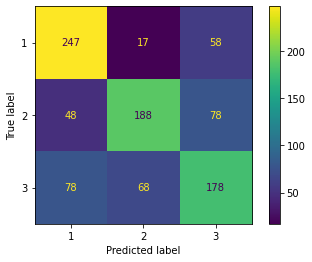


#### results for lowest loss model ####
Accuracy of: 0.6594


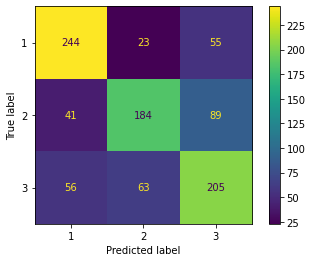


####################################################
# RESULTS FOR SUBJECT C
####################################################

#### results of training ####
Best training accuracy (max) 0.9531 @ epoch 429
Best training loss (min) 0.1609 @ epoch 432

Best validation accuracy (max) 0.8663 @ epoch 300
Best validation loss (min) 0.4087 @ epoch 337

#### results for highest accuracy model ####
Accuracy of: 0.6872


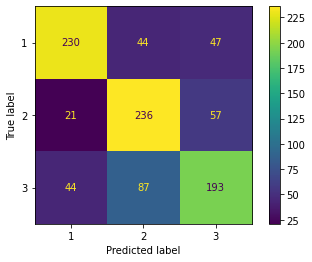


#### results for lowest loss model ####
Accuracy of: 0.6632


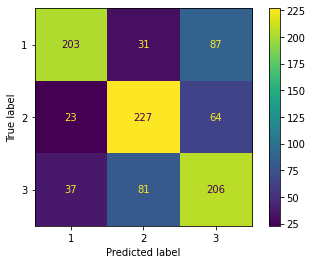


####################################################
# RESULTS FOR SUBJECT E
####################################################

#### results of training ####
Best training accuracy (max) 0.8248 @ epoch 397
Best training loss (min) 0.4601 @ epoch 397

Best validation accuracy (max) 0.7431 @ epoch 191
Best validation loss (min) 0.6214 @ epoch 191

#### results for highest accuracy model ####
Accuracy of: 0.6492


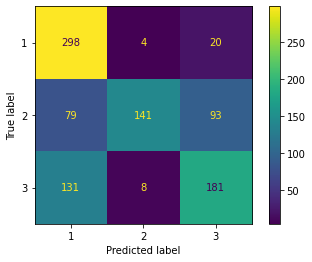


#### results for lowest loss model ####
Accuracy of: 0.6492


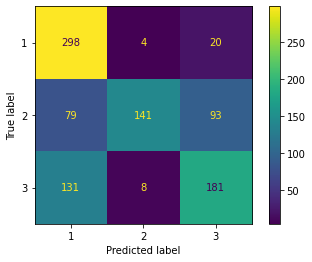

In [17]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/7/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get test data session
    with io.capture_output():
        # Get test data
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_test = mne_epochs.events[:, -1]
        
        # Get a half second window
        X_test = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
        
        # Fix scaling sensitivity as MNE stores as data * 10e-6
        X_test = X_test * 1000000
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
        
    # Get OHE from file
    with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id
del baseline
del end_offset
del start_offset